<a href="https://www.kaggle.com/code/atiaisaac/self-supervised-approach-to-image-classification?scriptVersionId=117413643" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# SimSiam in Tensorflow

The purpose of this notebook is to reproduce the results from the [simsiam paper](https://arxiv.org/pdf/2011.10566.pdf) albeit using the stanford dogs dataset as opposed to the cifar-10 dataset used in the original paper.

SimSiam is one of many self-supervised learning algorithms and thus shares some similaritiies. However, what makes SimSiam different is the fact that it does not rely on negative image pairs, clustering or a memory bank to avoid a degenerating solution. Instead, it cleverly uses a **stop gradient** operation and predictor MLP (an autoencoder structure) to learn semantic representations present in image data to avoid a collapsing solution. 

![simsiam](https://www.casualganpapers.com/assets/images/simsiam_teaser.png)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import gc
from dataclasses import dataclass
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from functools import partial
from tqdm import tqdm
try:
    import tensorflow_addons as tfa
except:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa
from datetime import datetime
# from resnet import ResNet18

In [2]:
now = datetime.now()
date = now.strftime("%Y %m %d")

In [3]:
gc.collect()
tf.keras.backend.clear_session()

In [4]:
@dataclass
class C:
#     BASE_LR = 5e-3
    DECAY = 1e-4
    EPOCHS = 400
    GLOBAL_BATCH_SIZE = 64 # * strategy.num_replicas_in_sync
    INIT_LR = 5e-4
    HEIGHT = 120
    AUTO = tf.data.experimental.AUTOTUNE
    PROJECTION_DIM = 2048
    LATENT_DIM = 512
    SEED = 42
    BUFFER_SIZE = 1028
    M = 0.6
    SHAPE = [HEIGHT,HEIGHT]
    SCALE = (0.2,1.0) #same scale used in simsiam paper
    CLASSES = 120
#     H = {"loss": [], "proj_std": [], "pred_std": []}

In [5]:
train,val,test = tfds.load(
    "stanford_dogs",
    as_supervised = True,
    split = ["train[:80%]","train[80%:]","test"]
)

2023-01-27 00:35:25.302403: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


2023-01-27 00:36:08.226044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 00:36:08.323510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 00:36:08.324411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 00:36:08.325483: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
print(tf.data.experimental.cardinality(train).numpy())
# print(tf.data.experimental.cardinality(query).numpy())
# print(tf.data.experimental.cardinality(index).numpy())
print(tf.data.experimental.cardinality(val).numpy())
print(tf.data.experimental.cardinality(test).numpy())

9600
2400
8580


In [7]:
x_train = train.map(lambda x, y: x)

### The SimSiam architecture requires that we make two augmented views of the same data. In the code cell below, we create functions for applying random augmentations

In [8]:
# https://github.com/sayakpaul/PAWS-TF/blob/main/utils/multicrop_loader.py#L86
# https://github.com/tensorflow/similarity/blob/master/tensorflow_similarity/augmenters/augmentation_utils/cropping.py
@tf.function
def _distorted_bounding_box_crop(
    image,bbox,min_object_covered=0.1,
    aspect_ratio_range=(0.75,1.33),
    area_range=(0.05,0.1),max_attempts=100
):
    shape = tf.shape(image)
    random_distorted_bbox = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes = bbox,
        min_object_covered = min_object_covered,
        aspect_ratio_range = aspect_ratio_range,
        area_range = area_range,
        max_attempts = max_attempts
    )
    offset,size,_ = random_distorted_bbox
    offset_y,offset_x,_ = tf.unstack(offset)
    target_y,target_x,_ = tf.unstack(size)
    image = tf.image.crop_to_bounding_box(
        image,offset_y,offset_x,target_y,target_x
    )
    return image

@tf.function    
def random_crop_resize(image,height,width,area_range=(0.08,1.0)):
    bbox = tf.constant([0.,0.,1.,1.],dtype=tf.float32,shape=[1,1,4])
    aspect_ratio = height / width
    image = _distorted_bounding_box_crop(
        image,bbox,aspect_ratio_range=(3.0/4.0 * aspect_ratio, 4.0/3.0 * aspect_ratio),
        area_range=area_range               
    )
    image = tf.image.resize(image,[height,width])
    return image

@tf.function
def gaussian_blur(image):
    image = tfa.image.gaussian_filter2d(image,sigma=(0.1,2.0))
                                       #filter_shape=(0.1*C.HEIGHT,0.1*C.HEIGHT))
    return image

def random_apply(func,image,prob):
    return tf.cond(
        tf.math.less(
            tf.random.uniform([],0,1,tf.float32),prob
        ),
        lambda:func(image),lambda:image
    )

@tf.function
def color_distortion(image,s=[0.4,0.4,0.4,0.1]):
    def _color_jitter(x):
        x = tf.image.random_brightness(x,max_delta = 0.8 * s[0])
        x = tf.image.random_contrast(x,
                                        lower = 1 - 0.8 * s[1],
                                        upper = 1 + 0.8 * s[1]
                                        )
        x = tf.image.random_saturation(x,
                                          lower = 1 - 0.8 * s[2],
                                          upper = 1 + 0.8 * s[2]
                                          )
        x = tf.image.random_hue(x,max_delta = 0.2 * s[3])
        x = tf.clip_by_value(x,0.,1.)
        return x

    def _color_drop(x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x,[1,1,3])
        return x
    
    image = random_apply(_color_jitter,image,0.8)
    image = random_apply(_color_drop,image,0.2)
    return image


def augment(image):
    image = random_crop_resize(image,C.HEIGHT,C.HEIGHT,area_range=C.SCALE) # prob = 1
    image = image/255.
    image = color_distortion(image)
    image = random_apply(gaussian_blur,image,0.5)
    image = tf.image.random_flip_left_right(image) # prob = 1 
    image = image * 255.
    return image 

## Random augmentations applied here to create two separate views

In [9]:
# for training
train_view_1 = (
    x_train.shuffle(C.BUFFER_SIZE,C.SEED)
    .map(lambda x: tf.image.resize(x,C.SHAPE),num_parallel_calls=C.AUTO)
    .map(augment,num_parallel_calls=C.AUTO)
    .batch(C.GLOBAL_BATCH_SIZE)
    .prefetch(C.AUTO)
)

train_view_2 = (
    x_train.shuffle(C.BUFFER_SIZE,C.SEED)
    .map(lambda x:tf.image.resize(x,C.SHAPE),num_parallel_calls=C.AUTO)
    .map(augment,num_parallel_calls=C.AUTO)
    .batch(C.GLOBAL_BATCH_SIZE)
    .prefetch(C.AUTO)
)

train_fused = tf.data.Dataset.zip((train_view_1,train_view_2))

print(train_fused)

<ZipDataset shapes: ((None, 120, 120, 3), (None, 120, 120, 3)), types: (tf.float32, tf.float32)>


# visualize the views

In [10]:
def visualize(sample):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(sample[n].numpy().astype('int'))
        plt.axis("off")
    plt.show()

2023-01-27 00:36:12.572841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


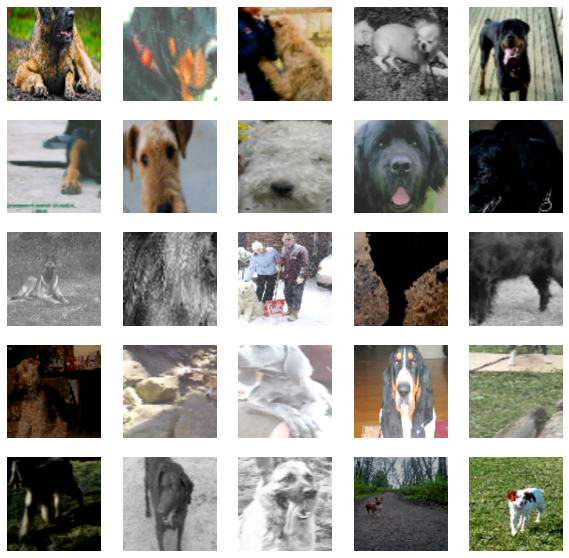

In [11]:
train_sample_one = next(iter(train_view_1))
visualize(train_sample_one)

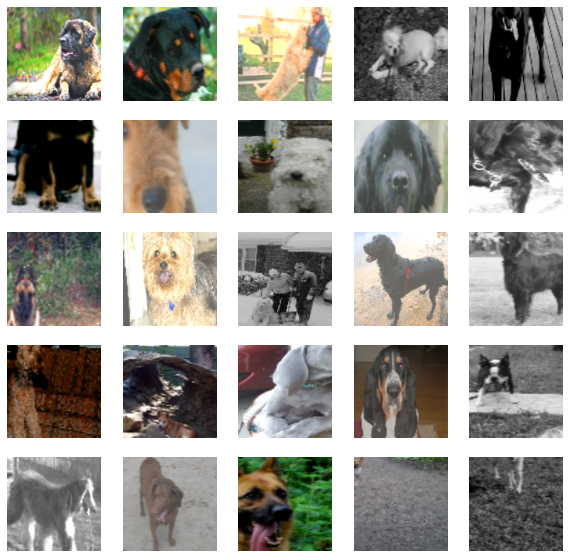

In [12]:
train_sample_two = next(iter(train_view_2))
visualize(train_sample_two)

This [example](https://keras.io/examples/vision/simsiam/) on the Keras website by Sayak Paul provides a tensorflow implementation of the Simsiam architecture from scratch - which is used in this notebook with some few modifications

In [13]:
class SimSiamLoss(tf.keras.losses.Loss):
    def __init__(self,name="loss",reduction=tf.keras.losses.Reduction.AUTO):
        super(SimSiamLoss,self).__init__(name=name,reduction=reduction)
    
    def call(self,projector,predictor):
        projector = tf.math.l2_normalize(projector,axis=1)
        predictor = tf.math.l2_normalize(predictor,axis=1)
        loss = tf.math.reduce_sum(projector * predictor,axis=1)
        return tf.constant([-1.0]) * loss
    
class MonitorStd(tf.keras.layers.Layer):
    def __init__(self,name):
        super(MonitorStd,self).__init__(name=name)
        
    def call(self,embedding):
        e = tf.math.l2_normalize(embedding,axis=-1)
        e = tf.math.reduce_std(e,axis=0)
        self.add_metric(e,name=self.name,aggregation="mean")
        return embedding

In [14]:
base = tf.keras.applications.resnet50.ResNet50(
    weights = "imagenet",
    include_top = False,
    input_shape = [*C.SHAPE,3],
)
base.trainable = False

def get_backbone():
    inputs = tf.keras.Input(shape=[*C.SHAPE,3])
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base(x,training=False)
    o = tf.keras.layers.GlobalAveragePooling2D()(x)
    return tf.keras.Model(inputs=inputs,outputs=o,name="backbone")

def get_projector(dim):
    # backbone
    inputs = tf.keras.Input(shape=[dim,])
#     x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
#     x = base(x)
#     x = tf.keras.layers.GlobalAveragePooling2D(name='backbone_pool')(x)

    # projection mlp - formats representations into the right form for applying contrastive loss
    x = tf.keras.layers.Dense(C.PROJECTION_DIM,
                              use_bias = False,
                              kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
                              kernel_initializer = tf.keras.initializers.LecunUniform(),
                              )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Dense(C.PROJECTION_DIM,
                              use_bias = False,
                              kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
                              kernel_initializer = tf.keras.initializers.LecunUniform(),
                              )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Dense(C.PROJECTION_DIM,
                              use_bias = False,
                              kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
                              kernel_initializer = tf.keras.initializers.LecunUniform(),
                              )(x)
    x = tf.keras.layers.BatchNormalization(center=False,scale=False)(x)
    o = MonitorStd(name="proj_std")(x)

    return tf.keras.Model(inputs=inputs,outputs=o,name='projector')

def get_predictor():
    inputs = tf.keras.Input(shape=[C.PROJECTION_DIM,])
    x = tf.keras.layers.Dense(C.LATENT_DIM,
                       use_bias = False,
                       kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
                        kernel_initializer = tf.keras.initializers.LecunUniform(),
                       )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Dense(C.PROJECTION_DIM,
                        kernel_initializer = tf.keras.initializers.LecunUniform()
                             )(x)
    o = MonitorStd(name="pred_std")(x)
    return tf.keras.Model(inputs=inputs,outputs=o,name="predictor")


94781440/94765736 [==============================] - 1s 0us/step


In [15]:
# with strategy.scope():
#     base = tf.keras.applications.resnet_v2.ResNet50V2(
#     weights = "imagenet",
#     include_top = False,
#     input_shape = [*C.SHAPE,3],
# )
#     base.trainable = False
backbone = get_backbone()
backbone.summary()

Model: "backbone"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 120, 120, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 120, 120, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
dim = backbone.output.shape[-1]
# with strategy.scope():
projector = get_projector(dim)
projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
re_lu (ReLU)                 (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4194304   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 2048)              0 

In [17]:
# with strategy.scope():
predictor = get_predictor()
predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              1050624   
_________________________________________________________________
pred_std (MonitorStd)        (None, 2048)              0         
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
___________________________________________

In [18]:
# with strategy.scope():
PRE_TRAIN_STEPS_PER_EPOCH = tf.data.experimental.cardinality(train).numpy() // C.GLOBAL_BATCH_SIZE
#     PRE_TEST_STEPS_PER_EPOCH = tf.data.experimental.cardinality(val) // C.GLOBAL_BATCH_SIZE
# steps = C.EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH

# lr_decay = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate = C.INIT_LR,
#     decay_steps = steps
# )

# weight_decay = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate = C.DECAY,
#     decay_steps = steps
# )

optimizer = tf.keras.optimizers.SGD(
    learning_rate = C.INIT_LR,
#     weight_decay = weight_decay,
    momentum = C.M
)
    
mcpt = tf.keras.callbacks.ModelCheckpoint(
    f"ckpts/loss_{date}",
    monitor = "loss",
    save_weights_only = True,
    verbose = 1
)

## uncomment when running on colab 
# tboard = tf.keras.callbacks.TensorBoard(
#     "simsiam/logs",
#     histogram_freq = 1,
#     update_freq = 10
# )

In [19]:
# plt.plot(range(steps),lr_decay(range(steps)))
# plt.xlabel("steps")
# plt.ylabel("learning rate")
# plt.title("Negative Loss Curve")

In [20]:
class SimSiam(tf.keras.Model):
    def __init__(self,backbone,projector,predictor):
        super(SimSiam,self).__init__()
        self.backbone = backbone
        self.projector = projector
        self.predictor = predictor
        
    
    @tf.function(jit_compile=True)
    def train_step(self,inputs):
        x1,x2 = inputs
        with tf.GradientTape() as tape:
            z1,z2,p1,p2,loss = self._forward_pass(x1,x2)
            reg_loss = sum(self.backbone.losses)
            reg_loss += sum(self.projector.losses)
            reg_loss += (sum(self.predictor.losses))
            total_loss = loss + reg_loss
        total_params = (
            self.backbone.trainable_variables +
            self.projector.trainable_variables +
            self.predictor.trainable_variables
        )
        grads = tape.gradient(total_loss,total_params)
        self.optimizer.apply_gradients(zip(grads,total_params))
        self.compiled_metrics.update_state([z1,z2],[p2,p1])
        return {m.name: m.result() for m in self.metrics}
    
    def _forward_pass(self,view1,view2):
        f1,f2 = self.backbone(view1), self.backbone(view2)
        z1,z2 = self.projector(f1), self.projector(f2)
        p1, p2 = self.predictor(z1), self.predictor(z2)

        l1 = self.compiled_loss(tf.stop_gradient(z1),p2)
        l2 = self.compiled_loss(tf.stop_gradient(z2),p1)
        loss = l1/2 + l2/2
        return z1,z2,p1,p2,loss

In [21]:
# with strategy.scope():
simsiam = SimSiam(backbone,projector,predictor)

simsiam.compile(
    optimizer = optimizer,
    loss = SimSiamLoss()
)

history = simsiam.fit(train_fused,
                  epochs=C.EPOCHS,
                  steps_per_epoch = PRE_TRAIN_STEPS_PER_EPOCH,
                  callbacks=[mcpt],
                  verbose=1)

Epoch 1/400


2023-01-27 00:36:30.298023: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55cdd1697100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-27 00:36:30.298094: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-01-27 00:36:30.870538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-27 00:36:34.736142: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  2/150 [..............................] - ETA: 10s - loss: 0.0027 - proj_std: 0.0134 - pred_std: 0.0122  

2023-01-27 00:36:42.613081: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 58/150 [==========>...................] - ETA: 26s - loss: -0.0234 - proj_std: 0.0134 - pred_std: 0.0122

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.0249 - proj_std: 0.0134 - pred_std: 0.0122

Cleanup called...


150/150 [==============================] - 62s 277ms/step - loss: -0.0644 - proj_std: 0.0134 - pred_std: 0.0118

Epoch 00001: saving model to ckpts/loss_2023 01 27
Epoch 2/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.1403 - proj_std: 0.0132 - pred_std: 0.0108

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.1410 - proj_std: 0.0132 - pred_std: 0.0108

Cleanup called...


150/150 [==============================] - 43s 271ms/step - loss: -0.1642 - proj_std: 0.0131 - pred_std: 0.0104

Epoch 00002: saving model to ckpts/loss_2023 01 27
Epoch 3/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.2104 - proj_std: 0.0129 - pred_std: 0.0096

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.2110 - proj_std: 0.0129 - pred_std: 0.0096

Cleanup called...


150/150 [==============================] - 44s 274ms/step - loss: -0.2266 - proj_std: 0.0128 - pred_std: 0.0093

Epoch 00003: saving model to ckpts/loss_2023 01 27
Epoch 4/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.2594 - proj_std: 0.0126 - pred_std: 0.0087

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.2598 - proj_std: 0.0126 - pred_std: 0.0087

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.2728 - proj_std: 0.0125 - pred_std: 0.0085

Epoch 00004: saving model to ckpts/loss_2023 01 27
Epoch 5/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.3009 - proj_std: 0.0123 - pred_std: 0.0081

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.3012 - proj_std: 0.0123 - pred_std: 0.0081

Cleanup called...


150/150 [==============================] - 43s 270ms/step - loss: -0.3131 - proj_std: 0.0123 - pred_std: 0.0079

Epoch 00005: saving model to ckpts/loss_2023 01 27
Epoch 6/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.3395 - proj_std: 0.0121 - pred_std: 0.0075

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.3398 - proj_std: 0.0121 - pred_std: 0.0075

Cleanup called...


150/150 [==============================] - 45s 275ms/step - loss: -0.3506 - proj_std: 0.0120 - pred_std: 0.0074

Epoch 00006: saving model to ckpts/loss_2023 01 27
Epoch 7/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.3744 - proj_std: 0.0119 - pred_std: 0.0071

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.3746 - proj_std: 0.0119 - pred_std: 0.0071

Cleanup called...


150/150 [==============================] - 43s 271ms/step - loss: -0.3844 - proj_std: 0.0118 - pred_std: 0.0070

Epoch 00007: saving model to ckpts/loss_2023 01 27
Epoch 8/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.4064 - proj_std: 0.0117 - pred_std: 0.0067

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.4066 - proj_std: 0.0117 - pred_std: 0.0067

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.4157 - proj_std: 0.0116 - pred_std: 0.0066

Epoch 00008: saving model to ckpts/loss_2023 01 27
Epoch 9/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.4366 - proj_std: 0.0115 - pred_std: 0.0064

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.4369 - proj_std: 0.0115 - pred_std: 0.0064

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.4456 - proj_std: 0.0114 - pred_std: 0.0063

Epoch 00009: saving model to ckpts/loss_2023 01 27
Epoch 10/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.4655 - proj_std: 0.0113 - pred_std: 0.0061

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.4657 - proj_std: 0.0113 - pred_std: 0.0061

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.4742 - proj_std: 0.0112 - pred_std: 0.0060

Epoch 00010: saving model to ckpts/loss_2023 01 27
Epoch 11/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.4933 - proj_std: 0.0111 - pred_std: 0.0059

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.4936 - proj_std: 0.0111 - pred_std: 0.0059

Cleanup called...


150/150 [==============================] - 43s 270ms/step - loss: -0.5016 - proj_std: 0.0111 - pred_std: 0.0058

Epoch 00011: saving model to ckpts/loss_2023 01 27
Epoch 12/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.5195 - proj_std: 0.0110 - pred_std: 0.0057

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.5198 - proj_std: 0.0110 - pred_std: 0.0057

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.5275 - proj_std: 0.0109 - pred_std: 0.0056

Epoch 00012: saving model to ckpts/loss_2023 01 27
Epoch 13/400
 56/150 [==========>...................] - ETA: 26s - loss: -0.5449 - proj_std: 0.0108 - pred_std: 0.0055

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.5453 - proj_std: 0.0108 - pred_std: 0.0055

Cleanup called...


150/150 [==============================] - 43s 272ms/step - loss: -0.5528 - proj_std: 0.0108 - pred_std: 0.0054

Epoch 00013: saving model to ckpts/loss_2023 01 27
Epoch 14/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.5699 - proj_std: 0.0107 - pred_std: 0.0053

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.5700 - proj_std: 0.0107 - pred_std: 0.0053

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.5769 - proj_std: 0.0106 - pred_std: 0.0052

Epoch 00014: saving model to ckpts/loss_2023 01 27
Epoch 15/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.5928 - proj_std: 0.0105 - pred_std: 0.0051

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.5930 - proj_std: 0.0105 - pred_std: 0.0051

Cleanup called...


150/150 [==============================] - 43s 274ms/step - loss: -0.5999 - proj_std: 0.0105 - pred_std: 0.0051

Epoch 00015: saving model to ckpts/loss_2023 01 27
Epoch 16/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.6149 - proj_std: 0.0104 - pred_std: 0.0050

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.6151 - proj_std: 0.0104 - pred_std: 0.0050

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.6214 - proj_std: 0.0104 - pred_std: 0.0049

Epoch 00016: saving model to ckpts/loss_2023 01 27
Epoch 17/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.6361 - proj_std: 0.0103 - pred_std: 0.0048

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.6362 - proj_std: 0.0103 - pred_std: 0.0048

Cleanup called...


150/150 [==============================] - 43s 271ms/step - loss: -0.6421 - proj_std: 0.0103 - pred_std: 0.0048

Epoch 00017: saving model to ckpts/loss_2023 01 27
Epoch 18/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.6557 - proj_std: 0.0102 - pred_std: 0.0047

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.6558 - proj_std: 0.0102 - pred_std: 0.0047

Cleanup called...


150/150 [==============================] - 43s 271ms/step - loss: -0.6615 - proj_std: 0.0102 - pred_std: 0.0047

Epoch 00018: saving model to ckpts/loss_2023 01 27
Epoch 19/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.6745 - proj_std: 0.0101 - pred_std: 0.0046

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.6746 - proj_std: 0.0101 - pred_std: 0.0046

Cleanup called...


150/150 [==============================] - 43s 273ms/step - loss: -0.6801 - proj_std: 0.0100 - pred_std: 0.0045

Epoch 00019: saving model to ckpts/loss_2023 01 27
Epoch 20/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.6923 - proj_std: 0.0100 - pred_std: 0.0045

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.6926 - proj_std: 0.0100 - pred_std: 0.0044

Cleanup called...


150/150 [==============================] - 44s 275ms/step - loss: -0.6977 - proj_std: 0.0099 - pred_std: 0.0044

Epoch 00020: saving model to ckpts/loss_2023 01 27
Epoch 21/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.7091 - proj_std: 0.0099 - pred_std: 0.0043

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.7092 - proj_std: 0.0099 - pred_std: 0.0043

Cleanup called...


150/150 [==============================] - 43s 272ms/step - loss: -0.7140 - proj_std: 0.0098 - pred_std: 0.0043

Epoch 00021: saving model to ckpts/loss_2023 01 27
Epoch 22/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.7248 - proj_std: 0.0098 - pred_std: 0.0042

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.7249 - proj_std: 0.0098 - pred_std: 0.0042

Cleanup called...


150/150 [==============================] - 43s 273ms/step - loss: -0.7291 - proj_std: 0.0097 - pred_std: 0.0042

Epoch 00022: saving model to ckpts/loss_2023 01 27
Epoch 23/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.7391 - proj_std: 0.0097 - pred_std: 0.0041

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.7392 - proj_std: 0.0097 - pred_std: 0.0041

Cleanup called...


150/150 [==============================] - 44s 273ms/step - loss: -0.7435 - proj_std: 0.0096 - pred_std: 0.0041

Epoch 00023: saving model to ckpts/loss_2023 01 27
Epoch 24/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.7528 - proj_std: 0.0096 - pred_std: 0.0040

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.7528 - proj_std: 0.0096 - pred_std: 0.0040

Cleanup called...


150/150 [==============================] - 43s 272ms/step - loss: -0.7567 - proj_std: 0.0096 - pred_std: 0.0040

Epoch 00024: saving model to ckpts/loss_2023 01 27
Epoch 25/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.7656 - proj_std: 0.0095 - pred_std: 0.0040

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.7657 - proj_std: 0.0095 - pred_std: 0.0040

Cleanup called...


150/150 [==============================] - 44s 272ms/step - loss: -0.7694 - proj_std: 0.0095 - pred_std: 0.0039

Epoch 00025: saving model to ckpts/loss_2023 01 27
Epoch 26/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.7775 - proj_std: 0.0094 - pred_std: 0.0039

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.7776 - proj_std: 0.0094 - pred_std: 0.0039

Cleanup called...


150/150 [==============================] - 43s 272ms/step - loss: -0.7811 - proj_std: 0.0094 - pred_std: 0.0039

Epoch 00026: saving model to ckpts/loss_2023 01 27
Epoch 27/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.7889 - proj_std: 0.0093 - pred_std: 0.0038

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.7889 - proj_std: 0.0093 - pred_std: 0.0038

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.7920 - proj_std: 0.0093 - pred_std: 0.0038

Epoch 00027: saving model to ckpts/loss_2023 01 27
Epoch 28/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.7990 - proj_std: 0.0093 - pred_std: 0.0037

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.7991 - proj_std: 0.0093 - pred_std: 0.0037

Cleanup called...


150/150 [==============================] - 43s 272ms/step - loss: -0.8019 - proj_std: 0.0092 - pred_std: 0.0037

Epoch 00028: saving model to ckpts/loss_2023 01 27
Epoch 29/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8085 - proj_std: 0.0092 - pred_std: 0.0037

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8086 - proj_std: 0.0092 - pred_std: 0.0037

Cleanup called...


150/150 [==============================] - 43s 273ms/step - loss: -0.8115 - proj_std: 0.0092 - pred_std: 0.0036

Epoch 00029: saving model to ckpts/loss_2023 01 27
Epoch 30/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8176 - proj_std: 0.0091 - pred_std: 0.0036

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.8177 - proj_std: 0.0091 - pred_std: 0.0036

Cleanup called...


150/150 [==============================] - 43s 273ms/step - loss: -0.8201 - proj_std: 0.0091 - pred_std: 0.0036

Epoch 00030: saving model to ckpts/loss_2023 01 27
Epoch 31/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8259 - proj_std: 0.0090 - pred_std: 0.0035

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8259 - proj_std: 0.0090 - pred_std: 0.0035

Cleanup called...


150/150 [==============================] - 43s 273ms/step - loss: -0.8284 - proj_std: 0.0090 - pred_std: 0.0035

Epoch 00031: saving model to ckpts/loss_2023 01 27
Epoch 32/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8334 - proj_std: 0.0090 - pred_std: 0.0035

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8335 - proj_std: 0.0090 - pred_std: 0.0035

Cleanup called...


150/150 [==============================] - 44s 272ms/step - loss: -0.8358 - proj_std: 0.0090 - pred_std: 0.0035

Epoch 00032: saving model to ckpts/loss_2023 01 27
Epoch 33/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8409 - proj_std: 0.0089 - pred_std: 0.0034

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8412 - proj_std: 0.0089 - pred_std: 0.0034

Cleanup called...


150/150 [==============================] - 44s 274ms/step - loss: -0.8430 - proj_std: 0.0089 - pred_std: 0.0034

Epoch 00033: saving model to ckpts/loss_2023 01 27
Epoch 34/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.8475 - proj_std: 0.0089 - pred_std: 0.0034

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.8476 - proj_std: 0.0089 - pred_std: 0.0034

Cleanup called...


150/150 [==============================] - 44s 274ms/step - loss: -0.8494 - proj_std: 0.0088 - pred_std: 0.0033

Epoch 00034: saving model to ckpts/loss_2023 01 27
Epoch 35/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8532 - proj_std: 0.0088 - pred_std: 0.0033

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8533 - proj_std: 0.0088 - pred_std: 0.0033

Cleanup called...


150/150 [==============================] - 44s 274ms/step - loss: -0.8553 - proj_std: 0.0088 - pred_std: 0.0033

Epoch 00035: saving model to ckpts/loss_2023 01 27
Epoch 36/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8590 - proj_std: 0.0088 - pred_std: 0.0033

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8591 - proj_std: 0.0088 - pred_std: 0.0033

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.8609 - proj_std: 0.0087 - pred_std: 0.0032

Epoch 00036: saving model to ckpts/loss_2023 01 27
Epoch 37/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8647 - proj_std: 0.0087 - pred_std: 0.0032

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8647 - proj_std: 0.0087 - pred_std: 0.0032

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.8663 - proj_std: 0.0087 - pred_std: 0.0032

Epoch 00037: saving model to ckpts/loss_2023 01 27
Epoch 38/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8698 - proj_std: 0.0086 - pred_std: 0.0032

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8698 - proj_std: 0.0086 - pred_std: 0.0032

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8710 - proj_std: 0.0086 - pred_std: 0.0032

Epoch 00038: saving model to ckpts/loss_2023 01 27
Epoch 39/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.8743 - proj_std: 0.0086 - pred_std: 0.0031

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.8744 - proj_std: 0.0086 - pred_std: 0.0031

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8757 - proj_std: 0.0086 - pred_std: 0.0031

Epoch 00039: saving model to ckpts/loss_2023 01 27
Epoch 40/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8787 - proj_std: 0.0085 - pred_std: 0.0031

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8787 - proj_std: 0.0085 - pred_std: 0.0031

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.8798 - proj_std: 0.0085 - pred_std: 0.0031

Epoch 00040: saving model to ckpts/loss_2023 01 27
Epoch 41/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8825 - proj_std: 0.0085 - pred_std: 0.0030

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8825 - proj_std: 0.0085 - pred_std: 0.0030

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8836 - proj_std: 0.0085 - pred_std: 0.0030

Epoch 00041: saving model to ckpts/loss_2023 01 27
Epoch 42/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8866 - proj_std: 0.0084 - pred_std: 0.0030

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8866 - proj_std: 0.0084 - pred_std: 0.0030

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.8873 - proj_std: 0.0084 - pred_std: 0.0030

Epoch 00042: saving model to ckpts/loss_2023 01 27
Epoch 43/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8898 - proj_std: 0.0084 - pred_std: 0.0030

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8898 - proj_std: 0.0084 - pred_std: 0.0030

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.8908 - proj_std: 0.0084 - pred_std: 0.0029

Epoch 00043: saving model to ckpts/loss_2023 01 27
Epoch 44/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8929 - proj_std: 0.0083 - pred_std: 0.0029

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8929 - proj_std: 0.0083 - pred_std: 0.0029

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.8937 - proj_std: 0.0083 - pred_std: 0.0029

Epoch 00044: saving model to ckpts/loss_2023 01 27
Epoch 45/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8958 - proj_std: 0.0083 - pred_std: 0.0029

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8958 - proj_std: 0.0083 - pred_std: 0.0029

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.8968 - proj_std: 0.0083 - pred_std: 0.0029

Epoch 00045: saving model to ckpts/loss_2023 01 27
Epoch 46/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8985 - proj_std: 0.0083 - pred_std: 0.0029

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8986 - proj_std: 0.0082 - pred_std: 0.0029

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.8994 - proj_std: 0.0082 - pred_std: 0.0028

Epoch 00046: saving model to ckpts/loss_2023 01 27
Epoch 47/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9012 - proj_std: 0.0082 - pred_std: 0.0028

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9012 - proj_std: 0.0082 - pred_std: 0.0028

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9020 - proj_std: 0.0082 - pred_std: 0.0028

Epoch 00047: saving model to ckpts/loss_2023 01 27
Epoch 48/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9038 - proj_std: 0.0082 - pred_std: 0.0028

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9038 - proj_std: 0.0082 - pred_std: 0.0028

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9044 - proj_std: 0.0081 - pred_std: 0.0028

Epoch 00048: saving model to ckpts/loss_2023 01 27
Epoch 49/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9059 - proj_std: 0.0081 - pred_std: 0.0028

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9058 - proj_std: 0.0081 - pred_std: 0.0028

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9065 - proj_std: 0.0081 - pred_std: 0.0028

Epoch 00049: saving model to ckpts/loss_2023 01 27
Epoch 50/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9081 - proj_std: 0.0081 - pred_std: 0.0027

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9081 - proj_std: 0.0081 - pred_std: 0.0027

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9086 - proj_std: 0.0081 - pred_std: 0.0027

Epoch 00050: saving model to ckpts/loss_2023 01 27
Epoch 51/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9099 - proj_std: 0.0081 - pred_std: 0.0027

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9099 - proj_std: 0.0081 - pred_std: 0.0027

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9105 - proj_std: 0.0080 - pred_std: 0.0027

Epoch 00051: saving model to ckpts/loss_2023 01 27
Epoch 52/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9114 - proj_std: 0.0080 - pred_std: 0.0027

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9115 - proj_std: 0.0080 - pred_std: 0.0027

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9122 - proj_std: 0.0080 - pred_std: 0.0027

Epoch 00052: saving model to ckpts/loss_2023 01 27
Epoch 53/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9139 - proj_std: 0.0080 - pred_std: 0.0026

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9139 - proj_std: 0.0080 - pred_std: 0.0026

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9141 - proj_std: 0.0080 - pred_std: 0.0026

Epoch 00053: saving model to ckpts/loss_2023 01 27
Epoch 54/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9151 - proj_std: 0.0079 - pred_std: 0.0026

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9152 - proj_std: 0.0079 - pred_std: 0.0026

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9155 - proj_std: 0.0079 - pred_std: 0.0026

Epoch 00054: saving model to ckpts/loss_2023 01 27
Epoch 55/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9168 - proj_std: 0.0079 - pred_std: 0.0026

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9168 - proj_std: 0.0079 - pred_std: 0.0026

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.9172 - proj_std: 0.0079 - pred_std: 0.0026

Epoch 00055: saving model to ckpts/loss_2023 01 27
Epoch 56/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9180 - proj_std: 0.0079 - pred_std: 0.0026

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9180 - proj_std: 0.0079 - pred_std: 0.0026

Cleanup called...


150/150 [==============================] - 44s 281ms/step - loss: -0.9183 - proj_std: 0.0079 - pred_std: 0.0026

Epoch 00056: saving model to ckpts/loss_2023 01 27
Epoch 57/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9197 - proj_std: 0.0078 - pred_std: 0.0025

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9197 - proj_std: 0.0078 - pred_std: 0.0025

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9199 - proj_std: 0.0078 - pred_std: 0.0025

Epoch 00057: saving model to ckpts/loss_2023 01 27
Epoch 58/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9206 - proj_std: 0.0078 - pred_std: 0.0025

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9206 - proj_std: 0.0078 - pred_std: 0.0025

Cleanup called...


150/150 [==============================] - 46s 287ms/step - loss: -0.9211 - proj_std: 0.0078 - pred_std: 0.0025

Epoch 00058: saving model to ckpts/loss_2023 01 27
Epoch 59/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9220 - proj_std: 0.0078 - pred_std: 0.0025

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9220 - proj_std: 0.0078 - pred_std: 0.0025

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9224 - proj_std: 0.0078 - pred_std: 0.0025

Epoch 00059: saving model to ckpts/loss_2023 01 27
Epoch 60/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9232 - proj_std: 0.0077 - pred_std: 0.0025

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9231 - proj_std: 0.0078 - pred_std: 0.0025

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.9234 - proj_std: 0.0077 - pred_std: 0.0025

Epoch 00060: saving model to ckpts/loss_2023 01 27
Epoch 61/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9243 - proj_std: 0.0077 - pred_std: 0.0025

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9243 - proj_std: 0.0077 - pred_std: 0.0025

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.9246 - proj_std: 0.0077 - pred_std: 0.0025

Epoch 00061: saving model to ckpts/loss_2023 01 27
Epoch 62/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9255 - proj_std: 0.0077 - pred_std: 0.0024

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9256 - proj_std: 0.0077 - pred_std: 0.0024

Cleanup called...


150/150 [==============================] - 46s 284ms/step - loss: -0.9257 - proj_std: 0.0077 - pred_std: 0.0024

Epoch 00062: saving model to ckpts/loss_2023 01 27
Epoch 63/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9263 - proj_std: 0.0077 - pred_std: 0.0024

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9263 - proj_std: 0.0077 - pred_std: 0.0024

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9266 - proj_std: 0.0077 - pred_std: 0.0024

Epoch 00063: saving model to ckpts/loss_2023 01 27
Epoch 64/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9272 - proj_std: 0.0076 - pred_std: 0.0024

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9272 - proj_std: 0.0076 - pred_std: 0.0024

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.9274 - proj_std: 0.0076 - pred_std: 0.0024

Epoch 00064: saving model to ckpts/loss_2023 01 27
Epoch 65/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9283 - proj_std: 0.0076 - pred_std: 0.0024

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9282 - proj_std: 0.0076 - pred_std: 0.0024

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9283 - proj_std: 0.0076 - pred_std: 0.0024

Epoch 00065: saving model to ckpts/loss_2023 01 27
Epoch 66/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9291 - proj_std: 0.0076 - pred_std: 0.0024

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9291 - proj_std: 0.0076 - pred_std: 0.0024

Cleanup called...


150/150 [==============================] - 46s 286ms/step - loss: -0.9293 - proj_std: 0.0076 - pred_std: 0.0024

Epoch 00066: saving model to ckpts/loss_2023 01 27
Epoch 67/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9300 - proj_std: 0.0075 - pred_std: 0.0023

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9299 - proj_std: 0.0075 - pred_std: 0.0023

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9300 - proj_std: 0.0075 - pred_std: 0.0023

Epoch 00067: saving model to ckpts/loss_2023 01 27
Epoch 68/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9307 - proj_std: 0.0075 - pred_std: 0.0023

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9307 - proj_std: 0.0075 - pred_std: 0.0023

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.9307 - proj_std: 0.0075 - pred_std: 0.0023

Epoch 00068: saving model to ckpts/loss_2023 01 27
Epoch 69/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9313 - proj_std: 0.0075 - pred_std: 0.0023

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9313 - proj_std: 0.0075 - pred_std: 0.0023

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9315 - proj_std: 0.0075 - pred_std: 0.0023

Epoch 00069: saving model to ckpts/loss_2023 01 27
Epoch 70/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9322 - proj_std: 0.0075 - pred_std: 0.0023

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9320 - proj_std: 0.0075 - pred_std: 0.0023

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.9323 - proj_std: 0.0075 - pred_std: 0.0023

Epoch 00070: saving model to ckpts/loss_2023 01 27
Epoch 71/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.9329 - proj_std: 0.0074 - pred_std: 0.0023

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9329 - proj_std: 0.0074 - pred_std: 0.0023

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9330 - proj_std: 0.0074 - pred_std: 0.0023

Epoch 00071: saving model to ckpts/loss_2023 01 27
Epoch 72/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.9335 - proj_std: 0.0074 - pred_std: 0.0023

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9335 - proj_std: 0.0074 - pred_std: 0.0023

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9337 - proj_std: 0.0074 - pred_std: 0.0022

Epoch 00072: saving model to ckpts/loss_2023 01 27
Epoch 73/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9340 - proj_std: 0.0074 - pred_std: 0.0022

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9340 - proj_std: 0.0074 - pred_std: 0.0022

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.9341 - proj_std: 0.0074 - pred_std: 0.0022

Epoch 00073: saving model to ckpts/loss_2023 01 27
Epoch 74/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9348 - proj_std: 0.0074 - pred_std: 0.0022

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9348 - proj_std: 0.0074 - pred_std: 0.0022

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9348 - proj_std: 0.0074 - pred_std: 0.0022

Epoch 00074: saving model to ckpts/loss_2023 01 27
Epoch 75/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9351 - proj_std: 0.0074 - pred_std: 0.0022

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9350 - proj_std: 0.0074 - pred_std: 0.0022

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9353 - proj_std: 0.0074 - pred_std: 0.0022

Epoch 00075: saving model to ckpts/loss_2023 01 27
Epoch 76/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9356 - proj_std: 0.0073 - pred_std: 0.0022

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9357 - proj_std: 0.0073 - pred_std: 0.0022

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9358 - proj_std: 0.0073 - pred_std: 0.0022

Epoch 00076: saving model to ckpts/loss_2023 01 27
Epoch 77/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9361 - proj_std: 0.0073 - pred_std: 0.0022

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9361 - proj_std: 0.0073 - pred_std: 0.0022

Cleanup called...


150/150 [==============================] - 44s 275ms/step - loss: -0.9363 - proj_std: 0.0073 - pred_std: 0.0022

Epoch 00077: saving model to ckpts/loss_2023 01 27
Epoch 78/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9365 - proj_std: 0.0073 - pred_std: 0.0022

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9365 - proj_std: 0.0073 - pred_std: 0.0022

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.9368 - proj_std: 0.0073 - pred_std: 0.0022

Epoch 00078: saving model to ckpts/loss_2023 01 27
Epoch 79/400
 59/150 [==========>...................] - ETA: 27s - loss: -0.9371 - proj_std: 0.0073 - pred_std: 0.0022

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9371 - proj_std: 0.0073 - pred_std: 0.0022

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9372 - proj_std: 0.0073 - pred_std: 0.0022

Epoch 00079: saving model to ckpts/loss_2023 01 27
Epoch 80/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9379 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9379 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


150/150 [==============================] - 43s 270ms/step - loss: -0.9381 - proj_std: 0.0072 - pred_std: 0.0021

Epoch 00080: saving model to ckpts/loss_2023 01 27
Epoch 81/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.9380 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9380 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


150/150 [==============================] - 44s 275ms/step - loss: -0.9382 - proj_std: 0.0072 - pred_std: 0.0021

Epoch 00081: saving model to ckpts/loss_2023 01 27
Epoch 82/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9384 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9384 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9386 - proj_std: 0.0072 - pred_std: 0.0021

Epoch 00082: saving model to ckpts/loss_2023 01 27
Epoch 83/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9388 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9389 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9391 - proj_std: 0.0072 - pred_std: 0.0021

Epoch 00083: saving model to ckpts/loss_2023 01 27
Epoch 84/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9395 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9395 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9396 - proj_std: 0.0072 - pred_std: 0.0021

Epoch 00084: saving model to ckpts/loss_2023 01 27
Epoch 85/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9399 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9399 - proj_std: 0.0072 - pred_std: 0.0021

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9400 - proj_std: 0.0071 - pred_std: 0.0021

Epoch 00085: saving model to ckpts/loss_2023 01 27
Epoch 86/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9404 - proj_std: 0.0071 - pred_std: 0.0021

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9404 - proj_std: 0.0071 - pred_std: 0.0021

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9404 - proj_std: 0.0071 - pred_std: 0.0021

Epoch 00086: saving model to ckpts/loss_2023 01 27
Epoch 87/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.9407 - proj_std: 0.0071 - pred_std: 0.0020

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9407 - proj_std: 0.0071 - pred_std: 0.0020

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9409 - proj_std: 0.0071 - pred_std: 0.0020

Epoch 00087: saving model to ckpts/loss_2023 01 27
Epoch 88/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9414 - proj_std: 0.0071 - pred_std: 0.0020

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9414 - proj_std: 0.0071 - pred_std: 0.0020

Cleanup called...


150/150 [==============================] - 45s 274ms/step - loss: -0.9414 - proj_std: 0.0071 - pred_std: 0.0020

Epoch 00088: saving model to ckpts/loss_2023 01 27
Epoch 89/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9417 - proj_std: 0.0071 - pred_std: 0.0020

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9416 - proj_std: 0.0071 - pred_std: 0.0020

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.9416 - proj_std: 0.0071 - pred_std: 0.0020

Epoch 00089: saving model to ckpts/loss_2023 01 27
Epoch 90/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9418 - proj_std: 0.0071 - pred_std: 0.0020

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9418 - proj_std: 0.0071 - pred_std: 0.0020

Cleanup called...


150/150 [==============================] - 45s 275ms/step - loss: -0.9420 - proj_std: 0.0071 - pred_std: 0.0020

Epoch 00090: saving model to ckpts/loss_2023 01 27
Epoch 91/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9424 - proj_std: 0.0070 - pred_std: 0.0020

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9424 - proj_std: 0.0070 - pred_std: 0.0020

Cleanup called...


150/150 [==============================] - 45s 277ms/step - loss: -0.9423 - proj_std: 0.0070 - pred_std: 0.0020

Epoch 00091: saving model to ckpts/loss_2023 01 27
Epoch 92/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9424 - proj_std: 0.0070 - pred_std: 0.0020

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9424 - proj_std: 0.0070 - pred_std: 0.0020

Cleanup called...


150/150 [==============================] - 44s 274ms/step - loss: -0.9427 - proj_std: 0.0070 - pred_std: 0.0020

Epoch 00092: saving model to ckpts/loss_2023 01 27
Epoch 93/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9428 - proj_std: 0.0070 - pred_std: 0.0020

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9428 - proj_std: 0.0070 - pred_std: 0.0020

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9429 - proj_std: 0.0070 - pred_std: 0.0020

Epoch 00093: saving model to ckpts/loss_2023 01 27
Epoch 94/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9431 - proj_std: 0.0070 - pred_std: 0.0020

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9431 - proj_std: 0.0070 - pred_std: 0.0020

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.9434 - proj_std: 0.0070 - pred_std: 0.0020

Epoch 00094: saving model to ckpts/loss_2023 01 27
Epoch 95/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9435 - proj_std: 0.0070 - pred_std: 0.0020

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9435 - proj_std: 0.0070 - pred_std: 0.0020

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9437 - proj_std: 0.0070 - pred_std: 0.0020

Epoch 00095: saving model to ckpts/loss_2023 01 27
Epoch 96/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9440 - proj_std: 0.0070 - pred_std: 0.0020

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9441 - proj_std: 0.0069 - pred_std: 0.0020

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.9439 - proj_std: 0.0070 - pred_std: 0.0020

Epoch 00096: saving model to ckpts/loss_2023 01 27
Epoch 97/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9442 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9442 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


150/150 [==============================] - 44s 273ms/step - loss: -0.9444 - proj_std: 0.0069 - pred_std: 0.0019

Epoch 00097: saving model to ckpts/loss_2023 01 27
Epoch 98/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9444 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9443 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9445 - proj_std: 0.0069 - pred_std: 0.0019

Epoch 00098: saving model to ckpts/loss_2023 01 27
Epoch 99/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9449 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9449 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.9449 - proj_std: 0.0069 - pred_std: 0.0019

Epoch 00099: saving model to ckpts/loss_2023 01 27
Epoch 100/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9452 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9452 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9451 - proj_std: 0.0069 - pred_std: 0.0019

Epoch 00100: saving model to ckpts/loss_2023 01 27
Epoch 101/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9454 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9454 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


150/150 [==============================] - 45s 276ms/step - loss: -0.9454 - proj_std: 0.0069 - pred_std: 0.0019

Epoch 00101: saving model to ckpts/loss_2023 01 27
Epoch 102/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9458 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9458 - proj_std: 0.0069 - pred_std: 0.0019

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.9456 - proj_std: 0.0069 - pred_std: 0.0019

Epoch 00102: saving model to ckpts/loss_2023 01 27
Epoch 103/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9462 - proj_std: 0.0068 - pred_std: 0.0019

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9462 - proj_std: 0.0068 - pred_std: 0.0019

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9461 - proj_std: 0.0068 - pred_std: 0.0019

Epoch 00103: saving model to ckpts/loss_2023 01 27
Epoch 104/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9462 - proj_std: 0.0068 - pred_std: 0.0019

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9462 - proj_std: 0.0068 - pred_std: 0.0019

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.9463 - proj_std: 0.0068 - pred_std: 0.0019

Epoch 00104: saving model to ckpts/loss_2023 01 27
Epoch 105/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9464 - proj_std: 0.0068 - pred_std: 0.0019

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9463 - proj_std: 0.0068 - pred_std: 0.0019

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9465 - proj_std: 0.0068 - pred_std: 0.0019

Epoch 00105: saving model to ckpts/loss_2023 01 27
Epoch 106/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9469 - proj_std: 0.0068 - pred_std: 0.0019

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9469 - proj_std: 0.0068 - pred_std: 0.0019

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.9468 - proj_std: 0.0068 - pred_std: 0.0019

Epoch 00106: saving model to ckpts/loss_2023 01 27
Epoch 107/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9469 - proj_std: 0.0068 - pred_std: 0.0019

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9469 - proj_std: 0.0068 - pred_std: 0.0019

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9469 - proj_std: 0.0068 - pred_std: 0.0019

Epoch 00107: saving model to ckpts/loss_2023 01 27
Epoch 108/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9472 - proj_std: 0.0068 - pred_std: 0.0018

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9473 - proj_std: 0.0068 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 44s 275ms/step - loss: -0.9473 - proj_std: 0.0068 - pred_std: 0.0018

Epoch 00108: saving model to ckpts/loss_2023 01 27
Epoch 109/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9477 - proj_std: 0.0068 - pred_std: 0.0018

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9476 - proj_std: 0.0068 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 45s 275ms/step - loss: -0.9476 - proj_std: 0.0068 - pred_std: 0.0018

Epoch 00109: saving model to ckpts/loss_2023 01 27
Epoch 110/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9479 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9479 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 45s 275ms/step - loss: -0.9479 - proj_std: 0.0067 - pred_std: 0.0018

Epoch 00110: saving model to ckpts/loss_2023 01 27
Epoch 111/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9483 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9482 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9481 - proj_std: 0.0067 - pred_std: 0.0018

Epoch 00111: saving model to ckpts/loss_2023 01 27
Epoch 112/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9484 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9484 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 45s 276ms/step - loss: -0.9483 - proj_std: 0.0067 - pred_std: 0.0018

Epoch 00112: saving model to ckpts/loss_2023 01 27
Epoch 113/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9485 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9485 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9485 - proj_std: 0.0067 - pred_std: 0.0018

Epoch 00113: saving model to ckpts/loss_2023 01 27
Epoch 114/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9488 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9488 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 45s 277ms/step - loss: -0.9488 - proj_std: 0.0067 - pred_std: 0.0018

Epoch 00114: saving model to ckpts/loss_2023 01 27
Epoch 115/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9489 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9490 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.9490 - proj_std: 0.0067 - pred_std: 0.0018

Epoch 00115: saving model to ckpts/loss_2023 01 27
Epoch 116/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9491 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9490 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9493 - proj_std: 0.0067 - pred_std: 0.0018

Epoch 00116: saving model to ckpts/loss_2023 01 27
Epoch 117/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9495 - proj_std: 0.0066 - pred_std: 0.0018

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9495 - proj_std: 0.0066 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9495 - proj_std: 0.0066 - pred_std: 0.0018

Epoch 00117: saving model to ckpts/loss_2023 01 27
Epoch 118/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9493 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9492 - proj_std: 0.0067 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.9495 - proj_std: 0.0066 - pred_std: 0.0018

Epoch 00118: saving model to ckpts/loss_2023 01 27
Epoch 119/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9500 - proj_std: 0.0066 - pred_std: 0.0018

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9500 - proj_std: 0.0066 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9499 - proj_std: 0.0066 - pred_std: 0.0018

Epoch 00119: saving model to ckpts/loss_2023 01 27
Epoch 120/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9504 - proj_std: 0.0066 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9504 - proj_std: 0.0066 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9502 - proj_std: 0.0066 - pred_std: 0.0018

Epoch 00120: saving model to ckpts/loss_2023 01 27
Epoch 121/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9500 - proj_std: 0.0066 - pred_std: 0.0018

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9500 - proj_std: 0.0066 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.9501 - proj_std: 0.0066 - pred_std: 0.0018

Epoch 00121: saving model to ckpts/loss_2023 01 27
Epoch 122/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9501 - proj_std: 0.0066 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9502 - proj_std: 0.0066 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9504 - proj_std: 0.0066 - pred_std: 0.0017

Epoch 00122: saving model to ckpts/loss_2023 01 27
Epoch 123/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9506 - proj_std: 0.0066 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9506 - proj_std: 0.0066 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.9507 - proj_std: 0.0066 - pred_std: 0.0017

Epoch 00123: saving model to ckpts/loss_2023 01 27
Epoch 124/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9508 - proj_std: 0.0066 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9508 - proj_std: 0.0066 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9509 - proj_std: 0.0066 - pred_std: 0.0017

Epoch 00124: saving model to ckpts/loss_2023 01 27
Epoch 125/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9508 - proj_std: 0.0066 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9508 - proj_std: 0.0066 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9510 - proj_std: 0.0066 - pred_std: 0.0017

Epoch 00125: saving model to ckpts/loss_2023 01 27
Epoch 126/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9513 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9513 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9512 - proj_std: 0.0065 - pred_std: 0.0017

Epoch 00126: saving model to ckpts/loss_2023 01 27
Epoch 127/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9516 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9516 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 46s 285ms/step - loss: -0.9515 - proj_std: 0.0065 - pred_std: 0.0017

Epoch 00127: saving model to ckpts/loss_2023 01 27
Epoch 128/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9515 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9514 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9516 - proj_std: 0.0065 - pred_std: 0.0017

Epoch 00128: saving model to ckpts/loss_2023 01 27
Epoch 129/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9519 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9520 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9520 - proj_std: 0.0065 - pred_std: 0.0017

Epoch 00129: saving model to ckpts/loss_2023 01 27
Epoch 130/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9519 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9518 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9519 - proj_std: 0.0065 - pred_std: 0.0017

Epoch 00130: saving model to ckpts/loss_2023 01 27
Epoch 131/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9523 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9523 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.9522 - proj_std: 0.0065 - pred_std: 0.0017

Epoch 00131: saving model to ckpts/loss_2023 01 27
Epoch 132/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9522 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9522 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.9523 - proj_std: 0.0065 - pred_std: 0.0017

Epoch 00132: saving model to ckpts/loss_2023 01 27
Epoch 133/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9524 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9524 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.9525 - proj_std: 0.0065 - pred_std: 0.0017

Epoch 00133: saving model to ckpts/loss_2023 01 27
Epoch 134/400
 59/150 [==========>...................] - ETA: 26s - loss: -0.9527 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9527 - proj_std: 0.0065 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.9528 - proj_std: 0.0064 - pred_std: 0.0017

Epoch 00134: saving model to ckpts/loss_2023 01 27
Epoch 135/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9528 - proj_std: 0.0064 - pred_std: 0.0017

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9528 - proj_std: 0.0064 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 44s 275ms/step - loss: -0.9527 - proj_std: 0.0065 - pred_std: 0.0017

Epoch 00135: saving model to ckpts/loss_2023 01 27
Epoch 136/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9530 - proj_std: 0.0064 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9530 - proj_std: 0.0064 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.9531 - proj_std: 0.0064 - pred_std: 0.0017

Epoch 00136: saving model to ckpts/loss_2023 01 27
Epoch 137/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9531 - proj_std: 0.0064 - pred_std: 0.0017

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9531 - proj_std: 0.0064 - pred_std: 0.0017

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.9531 - proj_std: 0.0064 - pred_std: 0.0017

Epoch 00137: saving model to ckpts/loss_2023 01 27
Epoch 138/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9532 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9533 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9534 - proj_std: 0.0064 - pred_std: 0.0016

Epoch 00138: saving model to ckpts/loss_2023 01 27
Epoch 139/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9535 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9535 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.9535 - proj_std: 0.0064 - pred_std: 0.0016

Epoch 00139: saving model to ckpts/loss_2023 01 27
Epoch 140/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9537 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9537 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9536 - proj_std: 0.0064 - pred_std: 0.0016

Epoch 00140: saving model to ckpts/loss_2023 01 27
Epoch 141/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.9539 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9540 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9539 - proj_std: 0.0064 - pred_std: 0.0016

Epoch 00141: saving model to ckpts/loss_2023 01 27
Epoch 142/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9540 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9539 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9540 - proj_std: 0.0064 - pred_std: 0.0016

Epoch 00142: saving model to ckpts/loss_2023 01 27
Epoch 143/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9543 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9543 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9542 - proj_std: 0.0064 - pred_std: 0.0016

Epoch 00143: saving model to ckpts/loss_2023 01 27
Epoch 144/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9542 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9542 - proj_std: 0.0064 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.9542 - proj_std: 0.0064 - pred_std: 0.0016

Epoch 00144: saving model to ckpts/loss_2023 01 27
Epoch 145/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9545 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9545 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.9545 - proj_std: 0.0063 - pred_std: 0.0016

Epoch 00145: saving model to ckpts/loss_2023 01 27
Epoch 146/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9545 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9544 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9545 - proj_std: 0.0063 - pred_std: 0.0016

Epoch 00146: saving model to ckpts/loss_2023 01 27
Epoch 147/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9549 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9549 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 46s 285ms/step - loss: -0.9549 - proj_std: 0.0063 - pred_std: 0.0016

Epoch 00147: saving model to ckpts/loss_2023 01 27
Epoch 148/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9549 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9549 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9550 - proj_std: 0.0063 - pred_std: 0.0016

Epoch 00148: saving model to ckpts/loss_2023 01 27
Epoch 149/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9550 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9550 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.9550 - proj_std: 0.0063 - pred_std: 0.0016

Epoch 00149: saving model to ckpts/loss_2023 01 27
Epoch 150/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9553 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9553 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9552 - proj_std: 0.0063 - pred_std: 0.0016

Epoch 00150: saving model to ckpts/loss_2023 01 27
Epoch 151/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9553 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9552 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 46s 279ms/step - loss: -0.9553 - proj_std: 0.0063 - pred_std: 0.0016

Epoch 00151: saving model to ckpts/loss_2023 01 27
Epoch 152/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9556 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9555 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.9554 - proj_std: 0.0063 - pred_std: 0.0016

Epoch 00152: saving model to ckpts/loss_2023 01 27
Epoch 153/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9555 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9555 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9555 - proj_std: 0.0063 - pred_std: 0.0016

Epoch 00153: saving model to ckpts/loss_2023 01 27
Epoch 154/400
 56/150 [==========>...................] - ETA: 29s - loss: -0.9559 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9559 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9558 - proj_std: 0.0063 - pred_std: 0.0016

Epoch 00154: saving model to ckpts/loss_2023 01 27
Epoch 155/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9559 - proj_std: 0.0063 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9559 - proj_std: 0.0062 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.9559 - proj_std: 0.0063 - pred_std: 0.0016

Epoch 00155: saving model to ckpts/loss_2023 01 27
Epoch 156/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9560 - proj_std: 0.0062 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9559 - proj_std: 0.0062 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.9561 - proj_std: 0.0062 - pred_std: 0.0016

Epoch 00156: saving model to ckpts/loss_2023 01 27
Epoch 157/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9562 - proj_std: 0.0062 - pred_std: 0.0016

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9562 - proj_std: 0.0062 - pred_std: 0.0016

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.9562 - proj_std: 0.0062 - pred_std: 0.0016

Epoch 00157: saving model to ckpts/loss_2023 01 27
Epoch 158/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9565 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9564 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9564 - proj_std: 0.0062 - pred_std: 0.0015

Epoch 00158: saving model to ckpts/loss_2023 01 27
Epoch 159/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9565 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9565 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9565 - proj_std: 0.0062 - pred_std: 0.0015

Epoch 00159: saving model to ckpts/loss_2023 01 27
Epoch 160/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9564 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9564 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9566 - proj_std: 0.0062 - pred_std: 0.0015

Epoch 00160: saving model to ckpts/loss_2023 01 27
Epoch 161/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9567 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9567 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 46s 292ms/step - loss: -0.9567 - proj_std: 0.0062 - pred_std: 0.0015

Epoch 00161: saving model to ckpts/loss_2023 01 27
Epoch 162/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9570 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9570 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9569 - proj_std: 0.0062 - pred_std: 0.0015

Epoch 00162: saving model to ckpts/loss_2023 01 27
Epoch 163/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9568 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9568 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 47s 286ms/step - loss: -0.9570 - proj_std: 0.0062 - pred_std: 0.0015

Epoch 00163: saving model to ckpts/loss_2023 01 27
Epoch 164/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9572 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9572 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 46s 284ms/step - loss: -0.9571 - proj_std: 0.0062 - pred_std: 0.0015

Epoch 00164: saving model to ckpts/loss_2023 01 27
Epoch 165/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9573 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9573 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.9571 - proj_std: 0.0062 - pred_std: 0.0015

Epoch 00165: saving model to ckpts/loss_2023 01 27
Epoch 166/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9573 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9573 - proj_std: 0.0062 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.9572 - proj_std: 0.0062 - pred_std: 0.0015

Epoch 00166: saving model to ckpts/loss_2023 01 27
Epoch 167/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9577 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9577 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.9575 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00167: saving model to ckpts/loss_2023 01 27
Epoch 168/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9575 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9575 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.9575 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00168: saving model to ckpts/loss_2023 01 27
Epoch 169/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9576 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9576 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9577 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00169: saving model to ckpts/loss_2023 01 27
Epoch 170/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.9580 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9580 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 46s 293ms/step - loss: -0.9579 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00170: saving model to ckpts/loss_2023 01 27
Epoch 171/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9579 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9578 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 44s 281ms/step - loss: -0.9578 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00171: saving model to ckpts/loss_2023 01 27
Epoch 172/400
 56/150 [==========>...................] - ETA: 29s - loss: -0.9580 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9581 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9581 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00172: saving model to ckpts/loss_2023 01 27
Epoch 173/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9584 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9584 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.9582 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00173: saving model to ckpts/loss_2023 01 27
Epoch 174/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9583 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9583 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9583 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00174: saving model to ckpts/loss_2023 01 27
Epoch 175/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9585 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9585 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.9584 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00175: saving model to ckpts/loss_2023 01 27
Epoch 176/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9583 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9583 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9584 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00176: saving model to ckpts/loss_2023 01 27
Epoch 177/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9586 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9585 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.9586 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00177: saving model to ckpts/loss_2023 01 27
Epoch 178/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9587 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9587 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9587 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00178: saving model to ckpts/loss_2023 01 27
Epoch 179/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9589 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9589 - proj_std: 0.0061 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.9588 - proj_std: 0.0061 - pred_std: 0.0015

Epoch 00179: saving model to ckpts/loss_2023 01 27
Epoch 180/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9590 - proj_std: 0.0060 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9590 - proj_std: 0.0060 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9590 - proj_std: 0.0060 - pred_std: 0.0015

Epoch 00180: saving model to ckpts/loss_2023 01 27
Epoch 181/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9590 - proj_std: 0.0060 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9589 - proj_std: 0.0060 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9590 - proj_std: 0.0060 - pred_std: 0.0015

Epoch 00181: saving model to ckpts/loss_2023 01 27
Epoch 182/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.9592 - proj_std: 0.0060 - pred_std: 0.0015

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.9592 - proj_std: 0.0060 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 47s 299ms/step - loss: -0.9591 - proj_std: 0.0060 - pred_std: 0.0015

Epoch 00182: saving model to ckpts/loss_2023 01 27
Epoch 183/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9592 - proj_std: 0.0060 - pred_std: 0.0015

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9592 - proj_std: 0.0060 - pred_std: 0.0015

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9592 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00183: saving model to ckpts/loss_2023 01 27
Epoch 184/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.9593 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9593 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9593 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00184: saving model to ckpts/loss_2023 01 27
Epoch 185/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.9595 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9595 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.9596 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00185: saving model to ckpts/loss_2023 01 27
Epoch 186/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9596 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9596 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9596 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00186: saving model to ckpts/loss_2023 01 27
Epoch 187/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9596 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9596 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9597 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00187: saving model to ckpts/loss_2023 01 27
Epoch 188/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9599 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9598 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 47s 286ms/step - loss: -0.9598 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00188: saving model to ckpts/loss_2023 01 27
Epoch 189/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9600 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9599 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.9599 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00189: saving model to ckpts/loss_2023 01 27
Epoch 190/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9599 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9599 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9599 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00190: saving model to ckpts/loss_2023 01 27
Epoch 191/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9601 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9601 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.9602 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00191: saving model to ckpts/loss_2023 01 27
Epoch 192/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9603 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9603 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.9602 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00192: saving model to ckpts/loss_2023 01 27
Epoch 193/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9603 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9603 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.9602 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00193: saving model to ckpts/loss_2023 01 27
Epoch 194/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9603 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9603 - proj_std: 0.0060 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.9603 - proj_std: 0.0060 - pred_std: 0.0014

Epoch 00194: saving model to ckpts/loss_2023 01 27
Epoch 195/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9605 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9605 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.9605 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00195: saving model to ckpts/loss_2023 01 27
Epoch 196/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9606 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9605 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9606 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00196: saving model to ckpts/loss_2023 01 27
Epoch 197/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9608 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9607 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.9607 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00197: saving model to ckpts/loss_2023 01 27
Epoch 198/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9608 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9608 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9608 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00198: saving model to ckpts/loss_2023 01 27
Epoch 199/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9610 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9610 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 44s 281ms/step - loss: -0.9610 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00199: saving model to ckpts/loss_2023 01 27
Epoch 200/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9609 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9609 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.9609 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00200: saving model to ckpts/loss_2023 01 27
Epoch 201/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9611 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9611 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.9611 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00201: saving model to ckpts/loss_2023 01 27
Epoch 202/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9612 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9611 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.9612 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00202: saving model to ckpts/loss_2023 01 27
Epoch 203/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9614 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9614 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.9613 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00203: saving model to ckpts/loss_2023 01 27
Epoch 204/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9612 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9612 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.9612 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00204: saving model to ckpts/loss_2023 01 27
Epoch 205/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9615 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9615 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.9614 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00205: saving model to ckpts/loss_2023 01 27
Epoch 206/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.9616 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9616 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.9615 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00206: saving model to ckpts/loss_2023 01 27
Epoch 207/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9616 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9616 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.9616 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00207: saving model to ckpts/loss_2023 01 27
Epoch 208/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9615 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9615 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9617 - proj_std: 0.0059 - pred_std: 0.0014

Epoch 00208: saving model to ckpts/loss_2023 01 27
Epoch 209/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9618 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9617 - proj_std: 0.0059 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 277ms/step - loss: -0.9618 - proj_std: 0.0058 - pred_std: 0.0014

Epoch 00209: saving model to ckpts/loss_2023 01 27
Epoch 210/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9619 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9619 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9618 - proj_std: 0.0058 - pred_std: 0.0014

Epoch 00210: saving model to ckpts/loss_2023 01 27
Epoch 211/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9620 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9620 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 44s 281ms/step - loss: -0.9619 - proj_std: 0.0058 - pred_std: 0.0014

Epoch 00211: saving model to ckpts/loss_2023 01 27
Epoch 212/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9621 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9621 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.9620 - proj_std: 0.0058 - pred_std: 0.0014

Epoch 00212: saving model to ckpts/loss_2023 01 27
Epoch 213/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9623 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9623 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9622 - proj_std: 0.0058 - pred_std: 0.0014

Epoch 00213: saving model to ckpts/loss_2023 01 27
Epoch 214/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.9622 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9622 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9622 - proj_std: 0.0058 - pred_std: 0.0014

Epoch 00214: saving model to ckpts/loss_2023 01 27
Epoch 215/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9621 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9621 - proj_std: 0.0058 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 277ms/step - loss: -0.9623 - proj_std: 0.0058 - pred_std: 0.0013

Epoch 00215: saving model to ckpts/loss_2023 01 27
Epoch 216/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9624 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9624 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.9624 - proj_std: 0.0058 - pred_std: 0.0013

Epoch 00216: saving model to ckpts/loss_2023 01 27
Epoch 217/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9628 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9628 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9625 - proj_std: 0.0058 - pred_std: 0.0013

Epoch 00217: saving model to ckpts/loss_2023 01 27
Epoch 218/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9624 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9624 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 285ms/step - loss: -0.9625 - proj_std: 0.0058 - pred_std: 0.0013

Epoch 00218: saving model to ckpts/loss_2023 01 27
Epoch 219/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9626 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9626 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.9627 - proj_std: 0.0058 - pred_std: 0.0013

Epoch 00219: saving model to ckpts/loss_2023 01 27
Epoch 220/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9627 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9627 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9627 - proj_std: 0.0058 - pred_std: 0.0013

Epoch 00220: saving model to ckpts/loss_2023 01 27
Epoch 221/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9628 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9628 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.9627 - proj_std: 0.0058 - pred_std: 0.0013

Epoch 00221: saving model to ckpts/loss_2023 01 27
Epoch 222/400
 56/150 [==========>...................] - ETA: 26s - loss: -0.9628 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9628 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.9628 - proj_std: 0.0058 - pred_std: 0.0013

Epoch 00222: saving model to ckpts/loss_2023 01 27
Epoch 223/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.9629 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9629 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.9629 - proj_std: 0.0058 - pred_std: 0.0013

Epoch 00223: saving model to ckpts/loss_2023 01 27
Epoch 224/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9631 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9631 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.9630 - proj_std: 0.0058 - pred_std: 0.0013

Epoch 00224: saving model to ckpts/loss_2023 01 27
Epoch 225/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9629 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9629 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 285ms/step - loss: -0.9630 - proj_std: 0.0058 - pred_std: 0.0013

Epoch 00225: saving model to ckpts/loss_2023 01 27
Epoch 226/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9630 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9631 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.9632 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00226: saving model to ckpts/loss_2023 01 27
Epoch 227/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9631 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9631 - proj_std: 0.0058 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9632 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00227: saving model to ckpts/loss_2023 01 27
Epoch 228/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9634 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9633 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9633 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00228: saving model to ckpts/loss_2023 01 27
Epoch 229/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9633 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9633 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 284ms/step - loss: -0.9634 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00229: saving model to ckpts/loss_2023 01 27
Epoch 230/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9634 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9633 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.9634 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00230: saving model to ckpts/loss_2023 01 27
Epoch 231/400
 56/150 [==========>...................] - ETA: 26s - loss: -0.9633 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9634 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 47s 284ms/step - loss: -0.9634 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00231: saving model to ckpts/loss_2023 01 27
Epoch 232/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9635 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9635 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9636 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00232: saving model to ckpts/loss_2023 01 27
Epoch 233/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9636 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9636 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 47s 282ms/step - loss: -0.9636 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00233: saving model to ckpts/loss_2023 01 27
Epoch 234/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9637 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9637 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 44s 282ms/step - loss: -0.9636 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00234: saving model to ckpts/loss_2023 01 27
Epoch 235/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9638 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9638 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.9639 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00235: saving model to ckpts/loss_2023 01 27
Epoch 236/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9638 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9639 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 286ms/step - loss: -0.9639 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00236: saving model to ckpts/loss_2023 01 27
Epoch 237/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9641 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9641 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 44s 281ms/step - loss: -0.9640 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00237: saving model to ckpts/loss_2023 01 27
Epoch 238/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9641 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9641 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.9640 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00238: saving model to ckpts/loss_2023 01 27
Epoch 239/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9639 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9640 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.9640 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00239: saving model to ckpts/loss_2023 01 27
Epoch 240/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9640 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9640 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.9640 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00240: saving model to ckpts/loss_2023 01 27
Epoch 241/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9642 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9642 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.9642 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00241: saving model to ckpts/loss_2023 01 27
Epoch 242/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9643 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9643 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 47s 281ms/step - loss: -0.9643 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00242: saving model to ckpts/loss_2023 01 27
Epoch 243/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9643 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9643 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.9644 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00243: saving model to ckpts/loss_2023 01 27
Epoch 244/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9644 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9644 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9644 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00244: saving model to ckpts/loss_2023 01 27
Epoch 245/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9644 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9644 - proj_std: 0.0057 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.9645 - proj_std: 0.0057 - pred_std: 0.0013

Epoch 00245: saving model to ckpts/loss_2023 01 27
Epoch 246/400
 59/150 [==========>...................] - ETA: 25s - loss: -0.9648 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9647 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.9646 - proj_std: 0.0056 - pred_std: 0.0013

Epoch 00246: saving model to ckpts/loss_2023 01 27
Epoch 247/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.9647 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9647 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9647 - proj_std: 0.0056 - pred_std: 0.0013

Epoch 00247: saving model to ckpts/loss_2023 01 27
Epoch 248/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9648 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9648 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 47s 293ms/step - loss: -0.9648 - proj_std: 0.0056 - pred_std: 0.0013

Epoch 00248: saving model to ckpts/loss_2023 01 27
Epoch 249/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.9646 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9646 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 44s 281ms/step - loss: -0.9648 - proj_std: 0.0056 - pred_std: 0.0013

Epoch 00249: saving model to ckpts/loss_2023 01 27
Epoch 250/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9648 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9647 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.9647 - proj_std: 0.0056 - pred_std: 0.0013

Epoch 00250: saving model to ckpts/loss_2023 01 27
Epoch 251/400
 56/150 [==========>...................] - ETA: 26s - loss: -0.9650 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9650 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9650 - proj_std: 0.0056 - pred_std: 0.0013

Epoch 00251: saving model to ckpts/loss_2023 01 27
Epoch 252/400
 59/150 [==========>...................] - ETA: 24s - loss: -0.9649 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9649 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 278ms/step - loss: -0.9648 - proj_std: 0.0056 - pred_std: 0.0013

Epoch 00252: saving model to ckpts/loss_2023 01 27
Epoch 253/400
 59/150 [==========>...................] - ETA: 26s - loss: -0.9651 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9651 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9650 - proj_std: 0.0056 - pred_std: 0.0013

Epoch 00253: saving model to ckpts/loss_2023 01 27
Epoch 254/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9650 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9650 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 44s 281ms/step - loss: -0.9651 - proj_std: 0.0056 - pred_std: 0.0013

Epoch 00254: saving model to ckpts/loss_2023 01 27
Epoch 255/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9653 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9652 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.9652 - proj_std: 0.0056 - pred_std: 0.0013

Epoch 00255: saving model to ckpts/loss_2023 01 27
Epoch 256/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9653 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9652 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 46s 284ms/step - loss: -0.9652 - proj_std: 0.0056 - pred_std: 0.0013

Epoch 00256: saving model to ckpts/loss_2023 01 27
Epoch 257/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 281ms/step - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Epoch 00257: saving model to ckpts/loss_2023 01 27
Epoch 258/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Epoch 00258: saving model to ckpts/loss_2023 01 27
Epoch 259/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9653 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9653 - proj_std: 0.0056 - pred_std: 0.0013

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.9653 - proj_std: 0.0056 - pred_std: 0.0012

Epoch 00259: saving model to ckpts/loss_2023 01 27
Epoch 260/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Epoch 00260: saving model to ckpts/loss_2023 01 27
Epoch 261/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.9654 - proj_std: 0.0056 - pred_std: 0.0012

Epoch 00261: saving model to ckpts/loss_2023 01 27
Epoch 262/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9656 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9656 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 288ms/step - loss: -0.9656 - proj_std: 0.0056 - pred_std: 0.0012

Epoch 00262: saving model to ckpts/loss_2023 01 27
Epoch 263/400
 56/150 [==========>...................] - ETA: 26s - loss: -0.9658 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9658 - proj_std: 0.0056 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.9657 - proj_std: 0.0056 - pred_std: 0.0012

Epoch 00263: saving model to ckpts/loss_2023 01 27
Epoch 264/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9658 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9659 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 284ms/step - loss: -0.9657 - proj_std: 0.0056 - pred_std: 0.0012

Epoch 00264: saving model to ckpts/loss_2023 01 27
Epoch 265/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9659 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9659 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9658 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00265: saving model to ckpts/loss_2023 01 27
Epoch 266/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.9659 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.9659 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9658 - proj_std: 0.0056 - pred_std: 0.0012

Epoch 00266: saving model to ckpts/loss_2023 01 27
Epoch 267/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9659 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9658 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 294ms/step - loss: -0.9658 - proj_std: 0.0056 - pred_std: 0.0012

Epoch 00267: saving model to ckpts/loss_2023 01 27
Epoch 268/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9659 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9660 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.9660 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00268: saving model to ckpts/loss_2023 01 27
Epoch 269/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9661 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9661 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 48s 291ms/step - loss: -0.9661 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00269: saving model to ckpts/loss_2023 01 27
Epoch 270/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9661 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9661 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 44s 281ms/step - loss: -0.9661 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00270: saving model to ckpts/loss_2023 01 27
Epoch 271/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9662 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9662 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 48s 288ms/step - loss: -0.9662 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00271: saving model to ckpts/loss_2023 01 27
Epoch 272/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9663 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9663 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.9663 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00272: saving model to ckpts/loss_2023 01 27
Epoch 273/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.9662 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9662 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 286ms/step - loss: -0.9663 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00273: saving model to ckpts/loss_2023 01 27
Epoch 274/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.9664 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9664 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 286ms/step - loss: -0.9663 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00274: saving model to ckpts/loss_2023 01 27
Epoch 275/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9665 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9665 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 282ms/step - loss: -0.9664 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00275: saving model to ckpts/loss_2023 01 27
Epoch 276/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9664 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9664 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 289ms/step - loss: -0.9665 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00276: saving model to ckpts/loss_2023 01 27
Epoch 277/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9665 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9665 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.9665 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00277: saving model to ckpts/loss_2023 01 27
Epoch 278/400
 59/150 [==========>...................] - ETA: 25s - loss: -0.9666 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9666 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.9665 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00278: saving model to ckpts/loss_2023 01 27
Epoch 279/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9665 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9665 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 46s 284ms/step - loss: -0.9665 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00279: saving model to ckpts/loss_2023 01 27
Epoch 280/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9668 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9668 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 46s 284ms/step - loss: -0.9667 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00280: saving model to ckpts/loss_2023 01 27
Epoch 281/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9666 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9666 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 288ms/step - loss: -0.9667 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00281: saving model to ckpts/loss_2023 01 27
Epoch 282/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9667 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9667 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.9667 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00282: saving model to ckpts/loss_2023 01 27
Epoch 283/400
 59/150 [==========>...................] - ETA: 27s - loss: -0.9669 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9669 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 291ms/step - loss: -0.9668 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00283: saving model to ckpts/loss_2023 01 27
Epoch 284/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9669 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9669 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.9669 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00284: saving model to ckpts/loss_2023 01 27
Epoch 285/400
 55/150 [==========>...................] - ETA: 27s - loss: -0.9670 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9671 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.9670 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00285: saving model to ckpts/loss_2023 01 27
Epoch 286/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9671 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9671 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.9670 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00286: saving model to ckpts/loss_2023 01 27
Epoch 287/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9670 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9671 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9670 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00287: saving model to ckpts/loss_2023 01 27
Epoch 288/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.9670 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.9669 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9670 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00288: saving model to ckpts/loss_2023 01 27
Epoch 289/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9671 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9670 - proj_std: 0.0055 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.9671 - proj_std: 0.0055 - pred_std: 0.0012

Epoch 00289: saving model to ckpts/loss_2023 01 27
Epoch 290/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9673 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9673 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 48s 288ms/step - loss: -0.9672 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00290: saving model to ckpts/loss_2023 01 27
Epoch 291/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9672 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9673 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9673 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00291: saving model to ckpts/loss_2023 01 27
Epoch 292/400
 59/150 [==========>...................] - ETA: 29s - loss: -0.9673 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9673 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 288ms/step - loss: -0.9674 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00292: saving model to ckpts/loss_2023 01 27
Epoch 293/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.9674 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9674 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 46s 295ms/step - loss: -0.9674 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00293: saving model to ckpts/loss_2023 01 27
Epoch 294/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9676 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9676 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9674 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00294: saving model to ckpts/loss_2023 01 27
Epoch 295/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.9673 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9673 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 286ms/step - loss: -0.9674 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00295: saving model to ckpts/loss_2023 01 27
Epoch 296/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9676 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9676 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 48s 292ms/step - loss: -0.9676 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00296: saving model to ckpts/loss_2023 01 27
Epoch 297/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9675 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9676 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.9675 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00297: saving model to ckpts/loss_2023 01 27
Epoch 298/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.9677 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.9677 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.9677 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00298: saving model to ckpts/loss_2023 01 27
Epoch 299/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9678 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9678 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 49s 295ms/step - loss: -0.9676 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00299: saving model to ckpts/loss_2023 01 27
Epoch 300/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9678 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9678 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 284ms/step - loss: -0.9677 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00300: saving model to ckpts/loss_2023 01 27
Epoch 301/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9677 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9677 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 289ms/step - loss: -0.9678 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00301: saving model to ckpts/loss_2023 01 27
Epoch 302/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9678 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9678 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.9678 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00302: saving model to ckpts/loss_2023 01 27
Epoch 303/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9679 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9679 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 289ms/step - loss: -0.9678 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00303: saving model to ckpts/loss_2023 01 27
Epoch 304/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9679 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9679 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9679 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00304: saving model to ckpts/loss_2023 01 27
Epoch 305/400
 56/150 [==========>...................] - ETA: 30s - loss: -0.9680 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9680 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.9681 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00305: saving model to ckpts/loss_2023 01 27
Epoch 306/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.9679 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9679 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 47s 299ms/step - loss: -0.9680 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00306: saving model to ckpts/loss_2023 01 27
Epoch 307/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.9682 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9681 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.9681 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00307: saving model to ckpts/loss_2023 01 27
Epoch 308/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9683 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9682 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.9681 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00308: saving model to ckpts/loss_2023 01 27
Epoch 309/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9683 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9682 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 48s 293ms/step - loss: -0.9682 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00309: saving model to ckpts/loss_2023 01 27
Epoch 310/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.9683 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9683 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 48s 293ms/step - loss: -0.9682 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00310: saving model to ckpts/loss_2023 01 27
Epoch 311/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9682 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9682 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 48s 287ms/step - loss: -0.9682 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00311: saving model to ckpts/loss_2023 01 27
Epoch 312/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9683 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9682 - proj_std: 0.0054 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 48s 292ms/step - loss: -0.9682 - proj_std: 0.0054 - pred_std: 0.0012

Epoch 00312: saving model to ckpts/loss_2023 01 27
Epoch 313/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9684 - proj_std: 0.0054 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9684 - proj_std: 0.0054 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 48s 290ms/step - loss: -0.9684 - proj_std: 0.0054 - pred_std: 0.0011

Epoch 00313: saving model to ckpts/loss_2023 01 27
Epoch 314/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9685 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9685 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.9684 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00314: saving model to ckpts/loss_2023 01 27
Epoch 315/400
 59/150 [==========>...................] - ETA: 27s - loss: -0.9685 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9685 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9685 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00315: saving model to ckpts/loss_2023 01 27
Epoch 316/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.9686 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9686 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 48s 304ms/step - loss: -0.9684 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00316: saving model to ckpts/loss_2023 01 27
Epoch 317/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9686 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9685 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 47s 286ms/step - loss: -0.9685 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00317: saving model to ckpts/loss_2023 01 27
Epoch 318/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9686 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9686 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 48s 291ms/step - loss: -0.9686 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00318: saving model to ckpts/loss_2023 01 27
Epoch 319/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9687 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9687 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.9686 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00319: saving model to ckpts/loss_2023 01 27
Epoch 320/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.9687 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9687 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.9687 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00320: saving model to ckpts/loss_2023 01 27
Epoch 321/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.9688 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.9687 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 47s 299ms/step - loss: -0.9687 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00321: saving model to ckpts/loss_2023 01 27
Epoch 322/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9688 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9688 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 48s 292ms/step - loss: -0.9688 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00322: saving model to ckpts/loss_2023 01 27
Epoch 323/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9688 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9689 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9689 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00323: saving model to ckpts/loss_2023 01 27
Epoch 324/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.9690 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.9690 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 47s 292ms/step - loss: -0.9689 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00324: saving model to ckpts/loss_2023 01 27
Epoch 325/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9690 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9690 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 47s 289ms/step - loss: -0.9688 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00325: saving model to ckpts/loss_2023 01 27
Epoch 326/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9689 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9689 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 286ms/step - loss: -0.9689 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00326: saving model to ckpts/loss_2023 01 27
Epoch 327/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9692 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9692 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 48s 292ms/step - loss: -0.9691 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00327: saving model to ckpts/loss_2023 01 27
Epoch 328/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9689 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9689 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9690 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00328: saving model to ckpts/loss_2023 01 27
Epoch 329/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.9691 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9691 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.9691 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00329: saving model to ckpts/loss_2023 01 27
Epoch 330/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9692 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9692 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.9691 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00330: saving model to ckpts/loss_2023 01 27
Epoch 331/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9691 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9691 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 43s 271ms/step - loss: -0.9691 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00331: saving model to ckpts/loss_2023 01 27
Epoch 332/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9693 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9693 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 274ms/step - loss: -0.9692 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00332: saving model to ckpts/loss_2023 01 27
Epoch 333/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9695 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9695 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.9693 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00333: saving model to ckpts/loss_2023 01 27
Epoch 334/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9694 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9693 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9693 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00334: saving model to ckpts/loss_2023 01 27
Epoch 335/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9694 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9694 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.9693 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00335: saving model to ckpts/loss_2023 01 27
Epoch 336/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9694 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9694 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 43s 270ms/step - loss: -0.9695 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00336: saving model to ckpts/loss_2023 01 27
Epoch 337/400
 56/150 [==========>...................] - ETA: 31s - loss: -0.9694 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9693 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.9694 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00337: saving model to ckpts/loss_2023 01 27
Epoch 338/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9696 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9696 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9695 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00338: saving model to ckpts/loss_2023 01 27
Epoch 339/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9697 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9697 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 43s 268ms/step - loss: -0.9695 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00339: saving model to ckpts/loss_2023 01 27
Epoch 340/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9695 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9695 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 277ms/step - loss: -0.9696 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00340: saving model to ckpts/loss_2023 01 27
Epoch 341/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9696 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9695 - proj_std: 0.0053 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.9696 - proj_std: 0.0053 - pred_std: 0.0011

Epoch 00341: saving model to ckpts/loss_2023 01 27
Epoch 342/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.9698 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9698 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9697 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00342: saving model to ckpts/loss_2023 01 27
Epoch 343/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9697 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9697 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.9696 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00343: saving model to ckpts/loss_2023 01 27
Epoch 344/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 43s 271ms/step - loss: -0.9697 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00344: saving model to ckpts/loss_2023 01 27
Epoch 345/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 278ms/step - loss: -0.9698 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00345: saving model to ckpts/loss_2023 01 27
Epoch 346/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9697 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9697 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9698 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00346: saving model to ckpts/loss_2023 01 27
Epoch 347/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9698 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9698 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00347: saving model to ckpts/loss_2023 01 27
Epoch 348/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9698 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00348: saving model to ckpts/loss_2023 01 27
Epoch 349/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9701 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9700 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 44s 274ms/step - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00349: saving model to ckpts/loss_2023 01 27
Epoch 350/400
 56/150 [==========>...................] - ETA: 30s - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 286ms/step - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00350: saving model to ckpts/loss_2023 01 27
Epoch 351/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9700 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9699 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.9700 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00351: saving model to ckpts/loss_2023 01 27
Epoch 352/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9701 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9701 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 273ms/step - loss: -0.9700 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00352: saving model to ckpts/loss_2023 01 27
Epoch 353/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9700 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9700 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.9700 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00353: saving model to ckpts/loss_2023 01 27
Epoch 354/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.9701 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9701 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 288ms/step - loss: -0.9701 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00354: saving model to ckpts/loss_2023 01 27
Epoch 355/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9700 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9700 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.9702 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00355: saving model to ckpts/loss_2023 01 27
Epoch 356/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9700 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9701 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 43s 270ms/step - loss: -0.9701 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00356: saving model to ckpts/loss_2023 01 27
Epoch 357/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.9703 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9703 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.9702 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00357: saving model to ckpts/loss_2023 01 27
Epoch 358/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9703 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9702 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 275ms/step - loss: -0.9702 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00358: saving model to ckpts/loss_2023 01 27
Epoch 359/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9703 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9703 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.9703 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00359: saving model to ckpts/loss_2023 01 27
Epoch 360/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9703 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9703 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9703 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00360: saving model to ckpts/loss_2023 01 27
Epoch 361/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9704 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9703 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 294ms/step - loss: -0.9704 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00361: saving model to ckpts/loss_2023 01 27
Epoch 362/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9705 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9705 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 43s 269ms/step - loss: -0.9704 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00362: saving model to ckpts/loss_2023 01 27
Epoch 363/400
 57/150 [==========>...................] - ETA: 31s - loss: -0.9705 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9705 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.9704 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00363: saving model to ckpts/loss_2023 01 27
Epoch 364/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9705 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9704 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9704 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00364: saving model to ckpts/loss_2023 01 27
Epoch 365/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9706 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9706 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 277ms/step - loss: -0.9705 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00365: saving model to ckpts/loss_2023 01 27
Epoch 366/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9707 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9707 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.9706 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00366: saving model to ckpts/loss_2023 01 27
Epoch 367/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9705 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9705 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 44s 271ms/step - loss: -0.9706 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00367: saving model to ckpts/loss_2023 01 27
Epoch 368/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9707 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9707 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9708 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00368: saving model to ckpts/loss_2023 01 27
Epoch 369/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.9706 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9706 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9706 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00369: saving model to ckpts/loss_2023 01 27
Epoch 370/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9708 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9708 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.9707 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00370: saving model to ckpts/loss_2023 01 27
Epoch 371/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 288ms/step - loss: -0.9708 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00371: saving model to ckpts/loss_2023 01 27
Epoch 372/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.9708 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9708 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.9708 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00372: saving model to ckpts/loss_2023 01 27
Epoch 373/400
 59/150 [==========>...................] - ETA: 27s - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 279ms/step - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00373: saving model to ckpts/loss_2023 01 27
Epoch 374/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9707 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9707 - proj_std: 0.0052 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.9707 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00374: saving model to ckpts/loss_2023 01 27
Epoch 375/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 43s 272ms/step - loss: -0.9708 - proj_std: 0.0052 - pred_std: 0.0011

Epoch 00375: saving model to ckpts/loss_2023 01 27
Epoch 376/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 285ms/step - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00376: saving model to ckpts/loss_2023 01 27
Epoch 377/400
 58/150 [==========>...................] - ETA: 30s - loss: -0.9710 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 292ms/step - loss: -0.9710 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00377: saving model to ckpts/loss_2023 01 27
Epoch 378/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9710 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00378: saving model to ckpts/loss_2023 01 27
Epoch 379/400
 56/150 [==========>...................] - ETA: 29s - loss: -0.9710 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9709 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 48s 301ms/step - loss: -0.9710 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00379: saving model to ckpts/loss_2023 01 27
Epoch 380/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00380: saving model to ckpts/loss_2023 01 27
Epoch 381/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 275ms/step - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00381: saving model to ckpts/loss_2023 01 27
Epoch 382/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00382: saving model to ckpts/loss_2023 01 27
Epoch 383/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 287ms/step - loss: -0.9712 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00383: saving model to ckpts/loss_2023 01 27
Epoch 384/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9711 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9712 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00384: saving model to ckpts/loss_2023 01 27
Epoch 385/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9712 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9712 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 44s 273ms/step - loss: -0.9712 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00385: saving model to ckpts/loss_2023 01 27
Epoch 386/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.9713 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00386: saving model to ckpts/loss_2023 01 27
Epoch 387/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 279ms/step - loss: -0.9713 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00387: saving model to ckpts/loss_2023 01 27
Epoch 388/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 277ms/step - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00388: saving model to ckpts/loss_2023 01 27
Epoch 389/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9715 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.9715 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00389: saving model to ckpts/loss_2023 01 27
Epoch 390/400
 57/150 [==========>...................] - ETA: 31s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 30s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 46s 294ms/step - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0011

Epoch 00390: saving model to ckpts/loss_2023 01 27
Epoch 391/400
 59/150 [==========>...................] - ETA: 26s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0010

Epoch 00391: saving model to ckpts/loss_2023 01 27
Epoch 392/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9714 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 46s 295ms/step - loss: -0.9715 - proj_std: 0.0051 - pred_std: 0.0010

Epoch 00392: saving model to ckpts/loss_2023 01 27
Epoch 393/400
 57/150 [==========>...................] - ETA: 31s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 30s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.9716 - proj_std: 0.0051 - pred_std: 0.0010

Epoch 00393: saving model to ckpts/loss_2023 01 27
Epoch 394/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9715 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9715 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.9716 - proj_std: 0.0051 - pred_std: 0.0010

Epoch 00394: saving model to ckpts/loss_2023 01 27
Epoch 395/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 43s 271ms/step - loss: -0.9716 - proj_std: 0.0051 - pred_std: 0.0010

Epoch 00395: saving model to ckpts/loss_2023 01 27
Epoch 396/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9718 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9718 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 46s 274ms/step - loss: -0.9716 - proj_std: 0.0051 - pred_std: 0.0010

Epoch 00396: saving model to ckpts/loss_2023 01 27
Epoch 397/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Epoch 00397: saving model to ckpts/loss_2023 01 27
Epoch 398/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Epoch 00398: saving model to ckpts/loss_2023 01 27
Epoch 399/400
 56/150 [==========>...................] - ETA: 26s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 45s 274ms/step - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Epoch 00399: saving model to ckpts/loss_2023 01 27
Epoch 400/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 46s 292ms/step - loss: -0.9717 - proj_std: 0.0051 - pred_std: 0.0010

Epoch 00400: saving model to ckpts/loss_2023 01 27


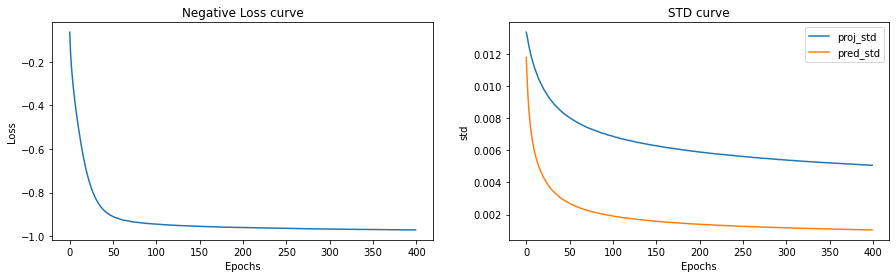

In [22]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Negative Loss curve")

plt.subplot(1,2,2)
plt.plot(history.history['proj_std'],label="proj_std")
plt.plot(history.history['pred_std'],label="pred_std")
plt.xlabel("Epochs")
plt.ylabel("std")
plt.title("STD curve") # range(0,1/sqrt(PROJECTION_DIM)) with 0 indicating a degenerate solution and vice versa
plt.legend()

In [23]:
backbone_path = f"backbone_{date}"
backbone.save(backbone_path)

2023-01-27 07:25:32.422870: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Performing downstream task to validate the model

In [24]:
# backbone = tf.keras.models.load_model("/kaggle/input/self-supervised-approach-to-image-classification/backbone_2023 01 25/")

In [25]:
backbone.trainable = False
def linear_model(num_classes):
    inputs = tf.keras.Input(shape=[*C.SHAPE,3])
    x = backbone(inputs,training=False)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(num_classes,activation="softmax")(x)
    return tf.keras.Model(inputs=inputs,outputs=x)

model = linear_model(C.CLASSES)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
backbone (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 245,880
Non-trainable params: 23,587,712
_________________________________________________________________


In [26]:
def preprocess(image,label,train=True):
#     image = tf.image.resize(image,C.SHAPE)
    if train:
#         image = tf.image.resize(image,C.SHAPE)
        image = random_crop_resize(image,C.HEIGHT,C.HEIGHT,area_range=C.SCALE)
        image = tf.image.random_flip_left_right(image)
        image = tf.clip_by_value(image,0.,255.)
        return image,label
    elif not train:
        image = tf.image.resize(image,C.SHAPE)
        return image,label

In [27]:
train_ds = (
    train.map(partial(preprocess,train=True),num_parallel_calls=C.AUTO)
    .shuffle(C.BUFFER_SIZE)
    .batch(64)
    .prefetch(C.AUTO)
)

val_ds = (
    val.map(partial(preprocess,train=False),num_parallel_calls=C.AUTO)
    .batch(64)
    .prefetch(C.AUTO)
)

x_test = (
    test.map(partial(preprocess,train=False),num_parallel_calls=C.AUTO)
    .map(lambda x,y: x)
    .batch(64)
)

# y_test = (
#     test.map(partial(preprocess,train=False),num_parallel_calls=C.AUTO)
#     .map(lambda x,y: y)
#     .batch(64)
# )

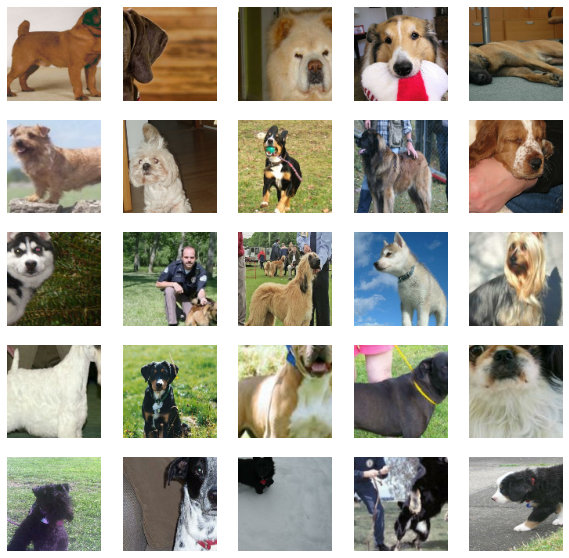

In [28]:
x,y = next(iter(train_ds))
visualize(x)

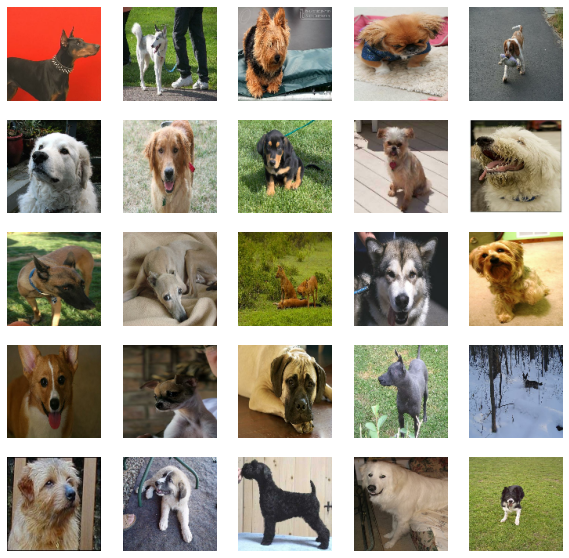

In [29]:
x,y = next(iter(val_ds))
visualize(x)

In [30]:
# steps = 20 * tf.data.experimental.cardinality(train_ds) 
# schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate = 30.0,
#     decay_steps = steps
# )


opt = tf.keras.optimizers.SGD(
    learning_rate = 30.0,
    momentum = 0.9
)

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = opt,
    metrics = ['accuracy']
)


hist = model.fit(
    train_ds,
    steps_per_epoch = train_ds.cardinality().numpy(),
    validation_data = val_ds,
    validation_steps = val_ds.cardinality().numpy(),
    epochs = 90,
    verbose = 1
)

Epoch 1/90
 62/150 [===========>..................] - ETA: 7s - loss: 11568.8301 - accuracy: 0.2815

Cleanup called...


150/150 [==============================] - 23s 123ms/step - loss: 10939.4727 - accuracy: 0.3698 - val_loss: 12066.4336 - val_accuracy: 0.3921
Epoch 2/90
 62/150 [===========>..................] - ETA: 8s - loss: 9276.0732 - accuracy: 0.5098

Cleanup called...


150/150 [==============================] - 17s 104ms/step - loss: 9334.9434 - accuracy: 0.5230 - val_loss: 12149.6553 - val_accuracy: 0.4454
Epoch 3/90
 62/150 [===========>..................] - ETA: 8s - loss: 9084.4297 - accuracy: 0.5441

Cleanup called...


150/150 [==============================] - 17s 107ms/step - loss: 8993.8877 - accuracy: 0.5519 - val_loss: 12912.6201 - val_accuracy: 0.4446
Epoch 4/90
 62/150 [===========>..................] - ETA: 8s - loss: 8338.1377 - accuracy: 0.5751

Cleanup called...


150/150 [==============================] - 17s 105ms/step - loss: 8445.8506 - accuracy: 0.5794 - val_loss: 12379.4062 - val_accuracy: 0.4708
Epoch 5/90
 62/150 [===========>..................] - ETA: 7s - loss: 7838.8271 - accuracy: 0.6162

Cleanup called...


150/150 [==============================] - 17s 101ms/step - loss: 8134.7642 - accuracy: 0.6041 - val_loss: 13655.2646 - val_accuracy: 0.4704
Epoch 6/90
 62/150 [===========>..................] - ETA: 8s - loss: 8014.9927 - accuracy: 0.6079

Cleanup called...


150/150 [==============================] - 18s 108ms/step - loss: 8285.5293 - accuracy: 0.6028 - val_loss: 14933.6035 - val_accuracy: 0.4654
Epoch 7/90
 61/150 [===========>..................] - ETA: 9s - loss: 8250.2246 - accuracy: 0.6212

Cleanup called...


150/150 [==============================] - 22s 139ms/step - loss: 7813.0225 - accuracy: 0.6335 - val_loss: 14291.7764 - val_accuracy: 0.4850
Epoch 8/90
 62/150 [===========>..................] - ETA: 8s - loss: 7591.2295 - accuracy: 0.6273

Cleanup called...


150/150 [==============================] - 18s 108ms/step - loss: 7343.0723 - accuracy: 0.6383 - val_loss: 15028.7080 - val_accuracy: 0.4633
Epoch 9/90
 62/150 [===========>..................] - ETA: 7s - loss: 7768.9912 - accuracy: 0.6426

Cleanup called...


150/150 [==============================] - 18s 113ms/step - loss: 7718.6035 - accuracy: 0.6366 - val_loss: 16056.8516 - val_accuracy: 0.4600
Epoch 10/90
 62/150 [===========>..................] - ETA: 7s - loss: 7515.6592 - accuracy: 0.6469

Cleanup called...


150/150 [==============================] - 17s 106ms/step - loss: 7476.1123 - accuracy: 0.6473 - val_loss: 14650.5420 - val_accuracy: 0.4888
Epoch 11/90
 62/150 [===========>..................] - ETA: 7s - loss: 7163.1807 - accuracy: 0.6613

Cleanup called...


150/150 [==============================] - 17s 102ms/step - loss: 7127.5977 - accuracy: 0.6612 - val_loss: 14474.5850 - val_accuracy: 0.4950
Epoch 12/90
 62/150 [===========>..................] - ETA: 8s - loss: 7005.4590 - accuracy: 0.6598

Cleanup called...


150/150 [==============================] - 17s 105ms/step - loss: 6967.5928 - accuracy: 0.6698 - val_loss: 14970.6221 - val_accuracy: 0.4921
Epoch 13/90
 62/150 [===========>..................] - ETA: 10s - loss: 6821.0171 - accuracy: 0.6855

Cleanup called...


150/150 [==============================] - 20s 119ms/step - loss: 6809.6724 - accuracy: 0.6837 - val_loss: 15573.4033 - val_accuracy: 0.4837
Epoch 14/90
 62/150 [===========>..................] - ETA: 7s - loss: 7540.3389 - accuracy: 0.6603

Cleanup called...


150/150 [==============================] - 19s 120ms/step - loss: 7183.1309 - accuracy: 0.6657 - val_loss: 15168.0615 - val_accuracy: 0.4950
Epoch 15/90
 62/150 [===========>..................] - ETA: 8s - loss: 6577.2944 - accuracy: 0.6789

Cleanup called...


150/150 [==============================] - 17s 106ms/step - loss: 6730.4517 - accuracy: 0.6789 - val_loss: 15147.5918 - val_accuracy: 0.4983
Epoch 16/90
 62/150 [===========>..................] - ETA: 8s - loss: 6706.1973 - accuracy: 0.6812

Cleanup called...


150/150 [==============================] - 21s 129ms/step - loss: 6568.7622 - accuracy: 0.6848 - val_loss: 14892.2588 - val_accuracy: 0.5038
Epoch 17/90
 62/150 [===========>..................] - ETA: 9s - loss: 7066.8564 - accuracy: 0.6832

Cleanup called...


150/150 [==============================] - 20s 125ms/step - loss: 6695.8643 - accuracy: 0.6897 - val_loss: 14201.9521 - val_accuracy: 0.5117
Epoch 18/90
 62/150 [===========>..................] - ETA: 8s - loss: 6337.6890 - accuracy: 0.6941

Cleanup called...


150/150 [==============================] - 17s 103ms/step - loss: 6435.7114 - accuracy: 0.6899 - val_loss: 14954.9814 - val_accuracy: 0.5083
Epoch 19/90
 62/150 [===========>..................] - ETA: 8s - loss: 6457.0059 - accuracy: 0.6865

Cleanup called...


150/150 [==============================] - 20s 122ms/step - loss: 6615.3340 - accuracy: 0.6889 - val_loss: 15999.1816 - val_accuracy: 0.4929
Epoch 20/90
 62/150 [===========>..................] - ETA: 7s - loss: 6904.9814 - accuracy: 0.6855

Cleanup called...


150/150 [==============================] - 17s 107ms/step - loss: 6660.2212 - accuracy: 0.6946 - val_loss: 15539.1387 - val_accuracy: 0.5117
Epoch 21/90
 62/150 [===========>..................] - ETA: 7s - loss: 6326.0791 - accuracy: 0.6971

Cleanup called...


150/150 [==============================] - 17s 102ms/step - loss: 6441.4600 - accuracy: 0.6898 - val_loss: 16139.7617 - val_accuracy: 0.5075
Epoch 22/90
 62/150 [===========>..................] - ETA: 10s - loss: 6486.2559 - accuracy: 0.7046

Cleanup called...


150/150 [==============================] - 19s 114ms/step - loss: 6456.1196 - accuracy: 0.7011 - val_loss: 16517.6738 - val_accuracy: 0.5096
Epoch 23/90
 62/150 [===========>..................] - ETA: 8s - loss: 5952.5405 - accuracy: 0.7198

Cleanup called...


150/150 [==============================] - 18s 109ms/step - loss: 6165.9785 - accuracy: 0.7125 - val_loss: 15706.3799 - val_accuracy: 0.5183
Epoch 24/90
 62/150 [===========>..................] - ETA: 7s - loss: 5834.3838 - accuracy: 0.7175

Cleanup called...


150/150 [==============================] - 17s 104ms/step - loss: 6126.3472 - accuracy: 0.7111 - val_loss: 16863.6445 - val_accuracy: 0.4958
Epoch 25/90
 62/150 [===========>..................] - ETA: 8s - loss: 6019.1411 - accuracy: 0.7268

Cleanup called...


150/150 [==============================] - 19s 117ms/step - loss: 6141.0366 - accuracy: 0.7250 - val_loss: 16558.7734 - val_accuracy: 0.5054
Epoch 26/90
 62/150 [===========>..................] - ETA: 8s - loss: 6476.6035 - accuracy: 0.7059

Cleanup called...


150/150 [==============================] - 17s 104ms/step - loss: 6019.6382 - accuracy: 0.7189 - val_loss: 15985.5498 - val_accuracy: 0.4996
Epoch 27/90
 62/150 [===========>..................] - ETA: 8s - loss: 5453.2910 - accuracy: 0.7351

Cleanup called...


150/150 [==============================] - 19s 120ms/step - loss: 5649.8276 - accuracy: 0.7308 - val_loss: 15324.7598 - val_accuracy: 0.5229
Epoch 28/90
 62/150 [===========>..................] - ETA: 7s - loss: 6045.5146 - accuracy: 0.7268

Cleanup called...


150/150 [==============================] - 17s 106ms/step - loss: 6170.0801 - accuracy: 0.7223 - val_loss: 16781.0938 - val_accuracy: 0.5154
Epoch 29/90
 61/150 [===========>..................] - ETA: 10s - loss: 6009.1367 - accuracy: 0.7293

Cleanup called...


150/150 [==============================] - 19s 115ms/step - loss: 5908.8491 - accuracy: 0.7268 - val_loss: 15674.6182 - val_accuracy: 0.5312
Epoch 30/90
 62/150 [===========>..................] - ETA: 8s - loss: 6087.7456 - accuracy: 0.7210

Cleanup called...


150/150 [==============================] - 18s 106ms/step - loss: 5914.1440 - accuracy: 0.7251 - val_loss: 16504.7090 - val_accuracy: 0.5183
Epoch 31/90
 62/150 [===========>..................] - ETA: 8s - loss: 5750.6392 - accuracy: 0.7288

Cleanup called...


150/150 [==============================] - 18s 109ms/step - loss: 5677.8838 - accuracy: 0.7317 - val_loss: 16138.0771 - val_accuracy: 0.5133
Epoch 32/90
 62/150 [===========>..................] - ETA: 7s - loss: 5614.0972 - accuracy: 0.7361

Cleanup called...


150/150 [==============================] - 20s 126ms/step - loss: 5577.1934 - accuracy: 0.7385 - val_loss: 17478.3809 - val_accuracy: 0.5092
Epoch 33/90
 61/150 [===========>..................] - ETA: 8s - loss: 5667.6411 - accuracy: 0.7293

Cleanup called...


150/150 [==============================] - 20s 123ms/step - loss: 5684.7944 - accuracy: 0.7272 - val_loss: 18203.0625 - val_accuracy: 0.4858
Epoch 34/90
 61/150 [===========>..................] - ETA: 7s - loss: 6125.7095 - accuracy: 0.7254

Cleanup called...


150/150 [==============================] - 19s 121ms/step - loss: 5758.8882 - accuracy: 0.7319 - val_loss: 17457.2363 - val_accuracy: 0.5063
Epoch 35/90
 62/150 [===========>..................] - ETA: 8s - loss: 5580.9438 - accuracy: 0.7371

Cleanup called...


150/150 [==============================] - 17s 105ms/step - loss: 5568.7373 - accuracy: 0.7390 - val_loss: 16886.8008 - val_accuracy: 0.5129
Epoch 36/90
 61/150 [===========>..................] - ETA: 11s - loss: 5289.7729 - accuracy: 0.7408

Cleanup called...


150/150 [==============================] - 20s 122ms/step - loss: 5458.7578 - accuracy: 0.7384 - val_loss: 17571.7461 - val_accuracy: 0.5033
Epoch 37/90
 62/150 [===========>..................] - ETA: 8s - loss: 5548.1279 - accuracy: 0.7419

Cleanup called...


150/150 [==============================] - 17s 104ms/step - loss: 5661.6064 - accuracy: 0.7404 - val_loss: 17007.8301 - val_accuracy: 0.5083
Epoch 38/90
 61/150 [===========>..................] - ETA: 7s - loss: 5583.0381 - accuracy: 0.7410

Cleanup called...


150/150 [==============================] - 17s 101ms/step - loss: 5574.4673 - accuracy: 0.7391 - val_loss: 16730.4902 - val_accuracy: 0.5129
Epoch 39/90
 62/150 [===========>..................] - ETA: 7s - loss: 5073.9536 - accuracy: 0.7472

Cleanup called...


150/150 [==============================] - 20s 120ms/step - loss: 5223.6152 - accuracy: 0.7472 - val_loss: 16878.3809 - val_accuracy: 0.5117
Epoch 40/90
 62/150 [===========>..................] - ETA: 8s - loss: 4734.9448 - accuracy: 0.7616

Cleanup called...


150/150 [==============================] - 17s 103ms/step - loss: 5109.5591 - accuracy: 0.7515 - val_loss: 17160.1699 - val_accuracy: 0.5146
Epoch 41/90
 62/150 [===========>..................] - ETA: 7s - loss: 5458.2925 - accuracy: 0.7455

Cleanup called...


150/150 [==============================] - 17s 105ms/step - loss: 5514.0981 - accuracy: 0.7439 - val_loss: 17653.5098 - val_accuracy: 0.5125
Epoch 42/90
 62/150 [===========>..................] - ETA: 7s - loss: 4815.4326 - accuracy: 0.7566

Cleanup called...


150/150 [==============================] - 17s 103ms/step - loss: 5102.9126 - accuracy: 0.7550 - val_loss: 17272.5020 - val_accuracy: 0.5250
Epoch 43/90
 62/150 [===========>..................] - ETA: 9s - loss: 5577.6353 - accuracy: 0.7434

Cleanup called...


150/150 [==============================] - 20s 127ms/step - loss: 5225.3799 - accuracy: 0.7576 - val_loss: 16996.2891 - val_accuracy: 0.5208
Epoch 44/90
 62/150 [===========>..................] - ETA: 8s - loss: 5631.4180 - accuracy: 0.7548

Cleanup called...


150/150 [==============================] - 18s 108ms/step - loss: 5368.8921 - accuracy: 0.7540 - val_loss: 17579.8516 - val_accuracy: 0.5146
Epoch 45/90
 62/150 [===========>..................] - ETA: 7s - loss: 5488.5562 - accuracy: 0.7460

Cleanup called...


150/150 [==============================] - 17s 102ms/step - loss: 5465.8130 - accuracy: 0.7464 - val_loss: 17884.6992 - val_accuracy: 0.5046
Epoch 46/90
 62/150 [===========>..................] - ETA: 7s - loss: 5176.0659 - accuracy: 0.7581

Cleanup called...


150/150 [==============================] - 18s 108ms/step - loss: 5248.0708 - accuracy: 0.7533 - val_loss: 17459.1797 - val_accuracy: 0.5250
Epoch 47/90
 62/150 [===========>..................] - ETA: 8s - loss: 5389.4658 - accuracy: 0.7500

Cleanup called...


150/150 [==============================] - 18s 103ms/step - loss: 5340.1685 - accuracy: 0.7531 - val_loss: 17197.9238 - val_accuracy: 0.5254
Epoch 48/90
 62/150 [===========>..................] - ETA: 8s - loss: 5421.2163 - accuracy: 0.7533

Cleanup called...


150/150 [==============================] - 17s 104ms/step - loss: 5298.3174 - accuracy: 0.7576 - val_loss: 17774.5078 - val_accuracy: 0.5129
Epoch 49/90
 62/150 [===========>..................] - ETA: 8s - loss: 5074.4575 - accuracy: 0.7613

Cleanup called...


150/150 [==============================] - 17s 107ms/step - loss: 5180.0962 - accuracy: 0.7608 - val_loss: 17430.2891 - val_accuracy: 0.5108
Epoch 50/90
 62/150 [===========>..................] - ETA: 9s - loss: 5335.5146 - accuracy: 0.7487

Cleanup called...


150/150 [==============================] - 22s 140ms/step - loss: 4853.3569 - accuracy: 0.7661 - val_loss: 17294.0840 - val_accuracy: 0.5267
Epoch 51/90
 62/150 [===========>..................] - ETA: 8s - loss: 5032.7168 - accuracy: 0.7611

Cleanup called...


150/150 [==============================] - 19s 121ms/step - loss: 5280.7524 - accuracy: 0.7543 - val_loss: 17870.7656 - val_accuracy: 0.5229
Epoch 52/90
 62/150 [===========>..................] - ETA: 8s - loss: 5036.9888 - accuracy: 0.7588

Cleanup called...


150/150 [==============================] - 19s 118ms/step - loss: 5219.5791 - accuracy: 0.7604 - val_loss: 18340.9219 - val_accuracy: 0.5021
Epoch 53/90
 62/150 [===========>..................] - ETA: 9s - loss: 5734.0605 - accuracy: 0.7452

Cleanup called...


150/150 [==============================] - 18s 109ms/step - loss: 5316.1074 - accuracy: 0.7619 - val_loss: 17671.8125 - val_accuracy: 0.5088
Epoch 54/90
 62/150 [===========>..................] - ETA: 7s - loss: 5585.5469 - accuracy: 0.7606

Cleanup called...


150/150 [==============================] - 17s 103ms/step - loss: 5296.2241 - accuracy: 0.7638 - val_loss: 17291.4102 - val_accuracy: 0.5221
Epoch 55/90
 62/150 [===========>..................] - ETA: 8s - loss: 5205.8149 - accuracy: 0.7719

Cleanup called...


150/150 [==============================] - 20s 122ms/step - loss: 4965.8784 - accuracy: 0.7717 - val_loss: 17327.2227 - val_accuracy: 0.5225
Epoch 56/90
 61/150 [===========>..................] - ETA: 11s - loss: 4868.4639 - accuracy: 0.7720

Cleanup called...


150/150 [==============================] - 20s 125ms/step - loss: 4880.5747 - accuracy: 0.7695 - val_loss: 17680.4961 - val_accuracy: 0.5096
Epoch 57/90
 62/150 [===========>..................] - ETA: 8s - loss: 5061.1870 - accuracy: 0.7671

Cleanup called...


150/150 [==============================] - 17s 103ms/step - loss: 4915.2109 - accuracy: 0.7705 - val_loss: 17435.3359 - val_accuracy: 0.5163
Epoch 58/90
 62/150 [===========>..................] - ETA: 8s - loss: 5220.3901 - accuracy: 0.7629

Cleanup called...


150/150 [==============================] - 18s 107ms/step - loss: 4959.7583 - accuracy: 0.7697 - val_loss: 16992.1523 - val_accuracy: 0.5196
Epoch 59/90
 62/150 [===========>..................] - ETA: 7s - loss: 5224.6533 - accuracy: 0.7631

Cleanup called...


150/150 [==============================] - 20s 124ms/step - loss: 4981.8027 - accuracy: 0.7656 - val_loss: 18911.4082 - val_accuracy: 0.5058
Epoch 60/90
 62/150 [===========>..................] - ETA: 7s - loss: 5273.0713 - accuracy: 0.7689

Cleanup called...


150/150 [==============================] - 16s 101ms/step - loss: 5285.8252 - accuracy: 0.7652 - val_loss: 17826.2500 - val_accuracy: 0.5138
Epoch 61/90
 62/150 [===========>..................] - ETA: 8s - loss: 4563.7305 - accuracy: 0.7807

Cleanup called...


150/150 [==============================] - 20s 123ms/step - loss: 4859.3408 - accuracy: 0.7735 - val_loss: 17924.9219 - val_accuracy: 0.5192
Epoch 62/90
 62/150 [===========>..................] - ETA: 7s - loss: 5165.0796 - accuracy: 0.7679

Cleanup called...


150/150 [==============================] - 16s 101ms/step - loss: 5056.1064 - accuracy: 0.7702 - val_loss: 18702.0820 - val_accuracy: 0.5125
Epoch 63/90
 62/150 [===========>..................] - ETA: 12s - loss: 4841.6157 - accuracy: 0.7724

Cleanup called...


150/150 [==============================] - 21s 129ms/step - loss: 4887.5352 - accuracy: 0.7692 - val_loss: 18800.1680 - val_accuracy: 0.5125
Epoch 64/90
 61/150 [===========>..................] - ETA: 7s - loss: 5329.7617 - accuracy: 0.7623

Cleanup called...


150/150 [==============================] - 17s 102ms/step - loss: 5157.6123 - accuracy: 0.7673 - val_loss: 19100.4043 - val_accuracy: 0.5083
Epoch 65/90
 62/150 [===========>..................] - ETA: 9s - loss: 5170.8716 - accuracy: 0.7646

Cleanup called...


150/150 [==============================] - 19s 119ms/step - loss: 4963.0601 - accuracy: 0.7749 - val_loss: 18296.2324 - val_accuracy: 0.5121
Epoch 66/90
 62/150 [===========>..................] - ETA: 7s - loss: 4811.7202 - accuracy: 0.7787

Cleanup called...


150/150 [==============================] - 17s 102ms/step - loss: 4883.0566 - accuracy: 0.7788 - val_loss: 18466.8457 - val_accuracy: 0.5208
Epoch 67/90
 62/150 [===========>..................] - ETA: 7s - loss: 4853.1597 - accuracy: 0.7825

Cleanup called...


150/150 [==============================] - 16s 101ms/step - loss: 4786.7646 - accuracy: 0.7782 - val_loss: 18319.9492 - val_accuracy: 0.5146
Epoch 68/90
 62/150 [===========>..................] - ETA: 7s - loss: 5078.0825 - accuracy: 0.7810

Cleanup called...


150/150 [==============================] - 17s 107ms/step - loss: 4841.1279 - accuracy: 0.7843 - val_loss: 18104.5840 - val_accuracy: 0.5267
Epoch 69/90
 62/150 [===========>..................] - ETA: 10s - loss: 5287.1064 - accuracy: 0.7722

Cleanup called...


150/150 [==============================] - 20s 121ms/step - loss: 4999.2500 - accuracy: 0.7792 - val_loss: 17800.6621 - val_accuracy: 0.5175
Epoch 70/90
 62/150 [===========>..................] - ETA: 7s - loss: 4877.2515 - accuracy: 0.7785

Cleanup called...


150/150 [==============================] - 17s 102ms/step - loss: 4808.0249 - accuracy: 0.7808 - val_loss: 17460.7031 - val_accuracy: 0.5188
Epoch 71/90
 62/150 [===========>..................] - ETA: 8s - loss: 4632.3691 - accuracy: 0.7785

Cleanup called...


150/150 [==============================] - 20s 124ms/step - loss: 4911.9902 - accuracy: 0.7758 - val_loss: 17983.9590 - val_accuracy: 0.5242
Epoch 72/90
 62/150 [===========>..................] - ETA: 7s - loss: 4929.4565 - accuracy: 0.7775

Cleanup called...


150/150 [==============================] - 19s 116ms/step - loss: 4926.5879 - accuracy: 0.7774 - val_loss: 18188.1914 - val_accuracy: 0.5067
Epoch 73/90
 61/150 [===========>..................] - ETA: 8s - loss: 4736.1489 - accuracy: 0.7828

Cleanup called...


150/150 [==============================] - 18s 105ms/step - loss: 4774.0259 - accuracy: 0.7792 - val_loss: 18103.5859 - val_accuracy: 0.5204
Epoch 74/90
 62/150 [===========>..................] - ETA: 8s - loss: 4893.5825 - accuracy: 0.7757

Cleanup called...


150/150 [==============================] - 19s 119ms/step - loss: 4770.0781 - accuracy: 0.7819 - val_loss: 19227.9668 - val_accuracy: 0.5133
Epoch 75/90
 62/150 [===========>..................] - ETA: 7s - loss: 4558.4600 - accuracy: 0.7787

Cleanup called...


150/150 [==============================] - 17s 102ms/step - loss: 4675.9458 - accuracy: 0.7830 - val_loss: 18105.2598 - val_accuracy: 0.5263
Epoch 76/90
 62/150 [===========>..................] - ETA: 8s - loss: 4296.2026 - accuracy: 0.7936

Cleanup called...


150/150 [==============================] - 23s 144ms/step - loss: 4352.1260 - accuracy: 0.7902 - val_loss: 19040.0391 - val_accuracy: 0.5138
Epoch 77/90
 62/150 [===========>..................] - ETA: 9s - loss: 4374.1538 - accuracy: 0.7908

Cleanup called...


150/150 [==============================] - 20s 124ms/step - loss: 4609.6006 - accuracy: 0.7857 - val_loss: 19425.8281 - val_accuracy: 0.5179
Epoch 78/90
 62/150 [===========>..................] - ETA: 8s - loss: 4629.2437 - accuracy: 0.7876

Cleanup called...


150/150 [==============================] - 17s 104ms/step - loss: 4682.9985 - accuracy: 0.7852 - val_loss: 19090.9512 - val_accuracy: 0.5192
Epoch 79/90
 62/150 [===========>..................] - ETA: 10s - loss: 4612.6914 - accuracy: 0.7795

Cleanup called...


150/150 [==============================] - 20s 116ms/step - loss: 4637.2686 - accuracy: 0.7836 - val_loss: 18590.2246 - val_accuracy: 0.5275
Epoch 80/90
 62/150 [===========>..................] - ETA: 8s - loss: 4887.0420 - accuracy: 0.7878

Cleanup called...


150/150 [==============================] - 18s 108ms/step - loss: 4918.0132 - accuracy: 0.7821 - val_loss: 18761.4141 - val_accuracy: 0.5233
Epoch 81/90
 62/150 [===========>..................] - ETA: 7s - loss: 5279.8564 - accuracy: 0.7772

Cleanup called...


150/150 [==============================] - 17s 103ms/step - loss: 4933.0635 - accuracy: 0.7789 - val_loss: 19693.6465 - val_accuracy: 0.5117
Epoch 82/90
 62/150 [===========>..................] - ETA: 8s - loss: 4198.3867 - accuracy: 0.7966

Cleanup called...


150/150 [==============================] - 19s 119ms/step - loss: 4429.7339 - accuracy: 0.7950 - val_loss: 19113.0762 - val_accuracy: 0.5125
Epoch 83/90
 62/150 [===========>..................] - ETA: 7s - loss: 4939.3589 - accuracy: 0.7722

Cleanup called...


150/150 [==============================] - 17s 103ms/step - loss: 4679.3350 - accuracy: 0.7834 - val_loss: 19556.9766 - val_accuracy: 0.5138
Epoch 84/90
 62/150 [===========>..................] - ETA: 7s - loss: 5143.1035 - accuracy: 0.7707

Cleanup called...


150/150 [==============================] - 17s 104ms/step - loss: 4778.4043 - accuracy: 0.7839 - val_loss: 18744.9863 - val_accuracy: 0.5288
Epoch 85/90
 62/150 [===========>..................] - ETA: 8s - loss: 5115.8955 - accuracy: 0.7765

Cleanup called...


150/150 [==============================] - 17s 107ms/step - loss: 4998.8613 - accuracy: 0.7816 - val_loss: 18844.2715 - val_accuracy: 0.5283
Epoch 86/90
 61/150 [===========>..................] - ETA: 9s - loss: 4375.1260 - accuracy: 0.7918

Cleanup called...


150/150 [==============================] - 20s 124ms/step - loss: 4532.9590 - accuracy: 0.7918 - val_loss: 18495.8457 - val_accuracy: 0.5167
Epoch 87/90
 62/150 [===========>..................] - ETA: 8s - loss: 4746.6089 - accuracy: 0.7835

Cleanup called...


150/150 [==============================] - 18s 109ms/step - loss: 4715.3013 - accuracy: 0.7869 - val_loss: 20057.0781 - val_accuracy: 0.5021
Epoch 88/90
 62/150 [===========>..................] - ETA: 8s - loss: 4715.4004 - accuracy: 0.7954

Cleanup called...


150/150 [==============================] - 19s 120ms/step - loss: 4572.7485 - accuracy: 0.7917 - val_loss: 19374.9707 - val_accuracy: 0.5096
Epoch 89/90
 62/150 [===========>..................] - ETA: 8s - loss: 4731.2876 - accuracy: 0.7916

Cleanup called...


150/150 [==============================] - 17s 106ms/step - loss: 4795.7827 - accuracy: 0.7921 - val_loss: 19463.8828 - val_accuracy: 0.5092
Epoch 90/90
 62/150 [===========>..................] - ETA: 10s - loss: 4959.0396 - accuracy: 0.7742

Cleanup called...


150/150 [==============================] - 20s 120ms/step - loss: 4710.9980 - accuracy: 0.7861 - val_loss: 19389.0645 - val_accuracy: 0.5263


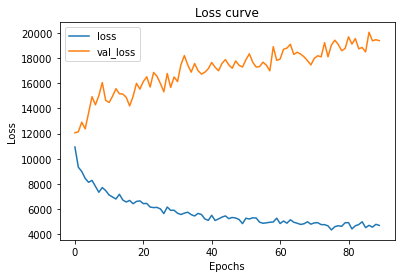

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss curve")
plt.legend(['loss','val_loss'])

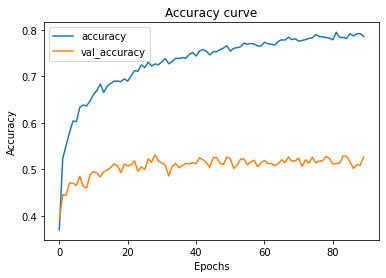

In [32]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curve")
plt.legend(["accuracy","val_accuracy"])

In [33]:
y_pred = np.argmax(model.predict(x_test),axis=1)

In [34]:
y = []
for _,b in test.as_numpy_iterator():
    y.append(b)

In [35]:
print(accuracy_score(y,y_pred))

0.5265734265734265
